<a href="https://colab.research.google.com/github/NilouGhazavi/Photoreceptor-inspired-CNN-Model-for-Object-Detection/blob/main/PRModel_with_CFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Functions**


In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random as random
import matplotlib.animation as animation
import pandas as pd
from random import sample
from tensorflow.keras import Sequential
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Input, InputLayer

from tensorflow.keras import backend as K
from tensorflow.keras import Model, regularizers, Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, Dense, Activation, Flatten, Reshape, MaxPool3D, MaxPool2D, Permute, BatchNormalization, GaussianNoise,DepthwiseConv2D, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l1, l2
import math
import sys



digit_max=10






#Dataset generating functions (Ines)


def generate_frames_dataset(digits_set, labels_set, n_digits=5, n_frames=1000, 
                            upsample=True, frame_size=280, 
                            downsample=False, pool_size=7, strides=7, final_size=4, 
                            movie=False, duration=5, 
                            perturbations = False, perturbations_time="random", perturbations_duration=2, half=False,
                            spot_proba = 1, spot_factor=100, shadow_factor=0.5,
                           digit_max = 10):
    
    """Generates a dataset of frames with n_digits, with variable frame_size, and possibilitiy to downsample, or movies (with identical frames) if movie=True. Adds light perturbations if perturbations=True, that can be 2 frames long homogenous or half frame light or shadow, at a specific time or random time. 
    
    Args:
    digits_set: np.array of MNIST digits
    labels_set: np.array of int type corresponding to the labels
    n_digits: int
    n_frames: int
    upsample; bool, True or False
    frame_size: if upsample, size of the frame after the upsampling, before the downsampling
    downsample: bool, True or False
    pool_size: int, if downsample
    strides: int, if downsample
    final_size: int
    movie: bool, True or False
    duration: int, if movie
    perturbations: bool, whether to add spotlights and shadows
    perturbations_time: str or int, when to start the 2-frames long perturbations
    half: bool, whether to add the perturbations on only half of the frame (if False : homogeneous perturbation)
    spot_proba: float, between 0 and 1, probability that the perturbation is a spotlight (0.5 if you want equiprobable spotlights and shadows)
    spot_factor: float, by how much to multiply the light intensity
    shadow_factor: float, but how much to multiply the light intensity as well ( < 1 )
    digit_max: maximum of the classes labels, by default 10. Can be less, if you only want to work with some of the classes, and reduce the MNIST dataset you use.
   
    Returns:
    dataset: np.array of frames (n_frames, final_size, final_size) or movies (n_frames, final_size, final_size, duration)
    labels_set: np.array of set of digit_max frames, corresponding to the labels for each class (n_frames, final_size, final_size, digit_max+1)
    
    """
    
    
    digit_shape = np.shape(digits_set[0])
    
    digit_max = len(list(set(labels_set)))
    frames = []
    labels = []
    	
    	
    if upsample:
        
        for i in range(n_frames):
        
            frame = np.zeros((frame_size, frame_size), dtype="float32")
            label = [np.zeros((frame_size, frame_size), dtype="float32" ) for i in range(digit_max)]  #build empty frames and labels


            indexes = random.sample(range(len(digits_set)), n_digits)  #select the MNIST digits, and get the corresponding labels
            digits = digits_set[indexes]
            digits_labels = labels_set[indexes]

            positions = [random.sample(range(frame_size-digit_shape[0]-1),2) for i in range(n_digits)]  #choose the position of the digits
            background = np.ones((frame_size, frame_size), dtype="float32")

            if downsample :
                
                new_frame_size, new_digits, new_positions = little_downsample(frame_size, digits, positions, pool_size, strides)
                #computing the downsampled positions and digits
                frame, label = create_frame_and_labels(new_frame_size, new_digits, digits_labels, new_positions, digit_max)
            
            else:
                
                frame, label = create_frame_and_labels(frame_size, digits, digits_labels, positions, digit_max)
            
            if movie:
            
            	frame = [frame for i in range(duration)]  #making a movie out of identical frames
            	
            	if perturbations:  #adding spotlights and shadows
            	
            		frame = add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, movie_duration, final_size)

            labels.append(label)
            frames.append(frame)
        
    else:  #if not upsampled
    
        for i in range(n_frames):

            n = random.randint(0,len(digits_set)-1)

            digit_label = labels_set[n]
            
            frame = digits_set[n]
            label = label_mnist(frame, digit_label, digit_max)

            
            if downsample:
                
                new_frame_size, new_digits, new_positions = little_downsample(frame_size, [frame], [[0,0]], pool_size, strides)
                frame, label = create_frame_and_labels(new_frame_size, new_digits, [digit_label], new_positions, digit_max)

            
            if movie:
            
            	frame = [frame for i in range(duration)]

            	if perturbations:
            	
            		frame = add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, perturbations_duration, duration)
				
            labels.append(label)
            frames.append(frame)
            
    dataset = np.array(frames)
    labels_set = np.array(labels)

    #getting the dimensions right for the model
    if not movie:
        dataset = dataset[:,:,:,None]
        labels_set = np.transpose(labels_set, (0,2,3,1))
    

    dataset = np.transpose(dataset, (0,2,3,1))
    labels_set = np.transpose(labels_set, (0,2,3,1))
    
    return dataset, labels_set
 
 
 
 
 
 
 
 
 
 
 


def generate_movie_dataset_5(digits_set, labels_set, 
                            n_movies=1000, duration=5,
                            frame_size = 280, n_digits=5,
                            depth=2, level=1,
                            shadow = False, shadow_ratio = 0.2, light_intensity = 0.1,
                            max_jump=1, speed=1,
                            digit_max = 10
                            ):
    
    """Generates a dataset of movies with moving digits
    
    Args:
    digits_set: np.array of MNIST digits
    labels_set: np.array of the corresponding labels
    n_movies: int, number of movies
    duration: int, duration of the movie
    frame_size: int, size of the frame
    n_digits: int, numer of digits
    shadow: bool, True or False
    shadow_ratio: float, usually 1/10**n, shadow surface/total surface, defines the radius. Reasonable circle size with ratio=0.3
    light_intensity: float, usually 10**n, factor applied to pixels in the shadow
    
    Returns:
    movies: np.array of movies, shape (n_movies, frame_size, frame_size, duration)
    labels: np. array of frames labelling the last frame of each movie for each class
    
    """
    
    radius = int(frame_size*np.sqrt(shadow_ratio/np.pi))
    
    movies, labels = [], []
    
    label_size = frame_size/2**(depth-level-1)

    digit_size = len(digits_set[0][0])
    
    for n in range(n_movies):
        
        # select the digits
        
        indexes = random.sample(range(len(digits_set)), n_digits)
        
        digits = digits_set[indexes]
        digits_labels = labels_set[indexes]
        
        #Initial values for the positions and directions of the digits
		
        positions = [random.sample(range(speed*max_jump, frame_size-digit_size-speed*max_jump),2) for i in range(n_digits)]
        directions =  [non_null_sample(max_jump, 2) for i in range(n_digits)]

        #create the movie and the movie labels
        
        movie = []
        
        for time in range(duration):

            for k, digit in enumerate(digits):
                
                #Compute the new position
                
                position = new_position(positions[k], directions[k], speed)
                positions[k] = position
                
                #Compute the next position to check it's going to be fine
                
                next_position = new_position(positions[k], directions[k], speed)

                while out_of_frame(next_position, frame_size, digit_size):
                
                    #Correct the direction if next position is out of frame
                    
                    rebound_point = closest_frontier(next_position, frame_size, digit_size)
                    directions[k] = mirror_direction(directions[k], rebound_point, frame_size)
                    next_position = new_position(positions[k], directions[k], speed)

                if in_the_center(positions[k], frame_size, speed, digit_size, max_jump):
                
                    #Randomly change the direction, if far enough from the walls
                    directions[k] = change_direction(directions[k], max_jump)
                    
            #Create the frame with the positions of the digits       
            frame = create_frame(frame_size, digits, positions)
            

            if shadow:
                frame = add_shadow(frame, radius, light_intensity)
                
            movie.append(frame)
            
            if time == duration-1 :
            
                    #only label the last time step
            
                    movie_labels = create_labels(frame_size, digits, digits_labels, positions, digit_max)

        movies.append(movie)
        labels.append(movie_labels)
        
    #Get the right shape for the model
    movies = np.transpose(movies, (0,2,3,1))
    labels = np.transpose(labels, (0,2,3,1))
        
    return np.array(movies), np.array(labels)









#Auxiliary functions for the generating functions (Ines)















def add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, perturbations_duration, movie_duration):

	"""
	
	Adds light level variations to a frame movie. Either on all the frame, or only half, either spotlight or shadow or both with a probability.
	
	Args:
	frame: 28x28 np array
	half: boolean
	spot_proba: 0 if only shadows, 1 if only spotlights, 0.5 if randomly one or the other.
	spot_factor: factor to multiply the pixel values if spotlight, usually 10**n
	shadow_factor: factor to multiply pixel values if shadow, usually 1/10**n
	perturbations_time: "random" by default, or int, has to be <= movie_duration-perturbations_duration
	perturbations_duration: int, in number of frames
	movie_duration: int
	final_size: int, size of the frame
	
	Returns:
	frame: modified frame
	
	"""
	frame_size = len(frame)

	if perturbations_time=="random":
	
		start_time = random.randint(0,movie_duration-perturbations_duration)
		
	else:
		start_time = perturbations_time
		
	end_time = start_time + perturbations_duration -1
	
	random_nb = np.random.random() #to decide if spotlight or shadow


	if half:
		random_half = np.random.randint(0,2)

		if random_half==1: #low half perturbated
		
			new_frames = []
			for k in range(perturbations_duration):
			
				new_frame = np.vstack([frame[start_time+k][:int(frame_size/2)] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor ) , frame[start_time+k][int(frame_size/2):]])
				new_frames.append(new_frame)
				
		else: #top half perturbated
		
			new_frames = []
			for k in range(perturbations_duration):
			
				new_frame = np.vstack([frame[start_time+k][:int(frame_size/2)], frame[start_time+k][int(frame_size/2):] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor )])
				new_frames.append(new_frame)

    			
	else:  #homogeneous perturbation
	
		new_frames = []
		for k in range(perturbations_duration):
		
			new_frame = frame[start_time+k] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor )
			new_frames.append(new_frame)

	for k in range(perturbations_duration):
	
		frame[start_time+k] = new_frames[k]

	return frame













def add_shadow(frame, radius, intensity):
    
    """Adds a shadow on a frame.
    
    Args:
    frame: np.array
    radius: float
    intensity: factor applied to the pixels in the shadow
    
    Returns:
    shad_frame: np.array of the frame with the shadow
    
    """
    
    frame_size = len(frame)
    shad_frame = frame.copy()
    
    for i,line in enumerate(frame):
        for j,pixel in enumerate(line):
            
            x,y  = i - frame_size/2, j - frame_size/2
            
            if np.sqrt(x**2 + y**2) <= radius :
                shad_frame[i,j] = intensity*frame[i,j]
                
    return shad_frame
















def create_labels(frame_size, digits, digits_labels, positions, digit_max):


    """Create the labels corresponding to a frame.
    
    Args:
    frame_size: float
    digits: MNIST digits present on the frame
    digits_labels: labels of the digits
    positions: 2-uple (x,y) for each digit
    digit_max: 10
    
    Returns:
    labels:frames corresponding to each class
    
    """
    
    labels = np.array([np.zeros((frame_size, frame_size)) for i in range(digit_max)]+ [np.ones((frame_size, frame_size))])

    for k, digit in enumerate(digits):

        
        frame = labels[digits_labels[k]]



        label_k = insert(digit, frame, positions[k])


        labels[digits_labels[k]] = label_k


        labels[-1] = np.maximum(labels[-1]-labels[digits_labels[k]], 0)
        
    return labels

















def label_mnist(digit_frame, digit, digit_max=10):

	
	"""
	
	Creates the labels frames corresponding to an MNIST digit
	
	Args:
	digit_frame: 28x28 np array, MNIST digit directly
	digit: int, MNIST label
	digit_max: int, default to 10
	
	Returns:
	labels: digit_max+1 frames, shape (digit_max+1, 28,28), with zeros on every frame but the digit frame, where the non zero MNIST pixels are =1.
	
	"""
	
	labels = [np.zeros(np.shape(digit_frame), dtype="float32") for i in range(digit_max+1)]

	label = np.zeros(np.shape(digit_frame), dtype="float32")
	for i in range(len(digit_frame)):
		for j in range(len(digit_frame[i])):
	    		if digit_frame[i][j] != 0:
	    			label[i][j] = 1

	labels[digit] = label
	labels[-1] = 1-label

	return labels















def insert(digit, frame, position):
    
    """
    
    Adds a digit in the frame. If there is already a digit, it has priority (the other is "hidden" behind)
    
    Args:
    digit: 28x28 array
    frame: array
    position: x,y for the digit's top left corner
    
    Outputs:
    frame: array
    
    """

    max_value = np.max(digit)
    for i, line in enumerate(digit):

        for j, pixel in enumerate(line):

            frame_value = frame[position[0]+i, position[1]+j]
            
            if frame_value == 0 :
                frame[position[0]+i, position[1]+j] = pixel
                
            #else : already a prioritary digit here

    
    return frame















def create_frame_and_labels(frame_size, digits, digits_labels, positions, digit_max):
    
    """Create a frame and the corresponding labels.
    
    Args:
    frame_size: int
    digits: np.array of MNIST digits to put on the frame
    digits_labels: np.array of int labels corresponding to the digits
    positions: 2-uple (x,y) for each digit
    digit_max: 10
    
    Returns:
    frame: the created frame
    labels: the associated label frames for each class
    
    """
    
    frame = np.zeros((frame_size, frame_size))
    background = np.ones((frame_size, frame_size))
    labels = [np.zeros((frame_size, frame_size)) for i in range(digit_max)]
    
    for k, digit in enumerate(digits):
        
        digit_label = digits_labels[k]
        position = positions[k]
        
        frame, labels[int(digit_label)], background = insert_and_label(digit, digit_label, frame, labels[int(digit_label)], position, background)
        
    labels.append(background)
        
    return np.array(frame), np.array(labels)

















def insert_and_label(digit, digit_label, frame, proba, position, background):

    """
    
    Adds a digit to a frame and to the corresponding labels
    
    Args:
    digit: MNIST digit
    digit_label: int
    frame: frame to insert the digit in
    proba: label drame corresponding to the digit
    position: (x,y) digit position
    background: background frame in the labels
    
    Returns:
    frame: modified frame
    new_proba: modified label frame
    background: modified background frame
    
    """
    

    new_proba = proba.copy()
    max_value = np.max(digit)
    
    for i, line in enumerate(digit):
        for j, pixel in enumerate(line):
            
            frame_value = frame[position[0]+i, position[1]+j]
            
            if frame_value == 0:
                frame[position[0]+i, position[1]+j] = pixel
                
            #else : already a digit there, priority to the first arrived
                
            if pixel != 0:
                
                new_proba[position[0]+i][position[1]+j] = 1
                background[position[0]+i][position[1]+j] = 0
                #where a non-zero digit pixel is inserted, a one is inserted in the same position of the corresponding matrix


    
    return frame, new_proba, background

















def downsample_digit(digits_list, 
                     pool_size, strides
                    ):
                    
    """
    
    Downsamples digits
    
    Args:
    digits_list: list of MNIST digits
    pool_size: int, for the downsampling
    strides: int, for the downsampling
    
    Returns:
    down_digits: list of downsampled digits
    new_digit_size: int
    
    """
    
    down_digits = []
    
    digit_size = len(digits_list[0][0])

    
    for digit in digits_list :


        down_digit = []
        line = 0

        while line < len(digit[0])-pool_size+1 :
            new_line = []
            column = 0
            while column < len(digit[0])-pool_size+1 :
        
                new_line.append(np.max( digit[line:line+pool_size, column:column+pool_size]))
                column += strides
        
            line += strides
            down_digit.append(new_line)
        
        down_digit= np.array(down_digit)


        down_digits.append(down_digit)
        new_digit_size = len(down_digits[0])
        
    return down_digits, new_digit_size












def little_downsample(frame_size, digits, positions, pool_size, strides):
    
    """Computes the new frame size, the new MNIST digits and their new positions after the downsampling. 
    Allows to create the downsampled frame rather then downsampling a frame, faster.
    
    Args:
    frame_size; int, before downsampling
    digits: MNIST digits
    positions: 2-uple (x,y) for each digit
    pool_size: int
    strides: int
    
    Returns:
    down_frame_size: int, new frame size
    down_digits: np.array of new digits
    down_positions: 2-uple of new (x,y) position for each digit
    
    """
    
    digit_size = len(digits[0][0])
    
    down_frame_size = (frame_size-pool_size)/strides +1
    down_positions = []
    down_digits = []
    
    for position in positions:
        x,y = position
        down_x, down_y = x//strides, y//strides
        down_positions.append([down_x,down_y])
        
        
    down_digits, digit_size = downsample_digit(digits, pool_size, strides)

        
    return int(down_frame_size), down_digits, down_positions
















def create_frame(frame_size, digits, positions):
    
    """
    
    Creates the frame zith all the digits.
    
    Args:
    frame_size: for a square frame
    digits: list of 28x28 arrays
    positions: list of x,y corresponding to the digits' top left corners, in the same order
    
    Outputs:
    frame: 280x280 array
    
    """
    
    frame = np.zeros((frame_size, frame_size))
    for k, digit in enumerate(digits):
        position = positions[k]
        frame = insert(digit, frame, position)
    return frame

















def mirror_direction(direction, position, frame_size):
    
    """
    
    Finds the new direction when a digit rebounds on a wall.
    
    Args:
    direction: current direction of the digit [dx,dy] 
    position: current position of the digit [x,y]
    frame_size: for a square frame
    
    Outputs:
    direction: [dx,dy]
    
    """
    
    dx, dy = direction
    x,y = position
    if (x==0 or x==frame_size-1) and y!=0 and y!=frame_size-1:
        dx = -dx
    if (y==0 or y==frame_size-1) and x!=0 and x!=frame_size-1:
        dy = -dy
    if (x==0 or x==frame_size-1) and (y==0 or y==frame_size-1):
        dx, dy = -dx, -dy
    return [dx, dy]


















def change_direction(direction, max_jump):
    
    """
    
    Generates a slight change in direction, called with a small probability.
    
    Args:
    direction: current direction [dx,dy]
    max_jump: initially defined constant
    
    Outputs:
    direction: new direction[dx,dy]
    
    """
    
    random_nb = random.random()
    if random_nb < 0.05:
        direction[0] = min(max_jump, max(-max_jump,direction[0]+1))
        # to check that still between -max_jump and max_jump
    elif random_nb >= 0.05 and random_nb < 0.1 :
        direction[0] = min(max_jump, max(-max_jump,direction[0]-1))
    if random_nb >= 0.1 and random_nb < 0.15:
        direction[1] = min(max_jump, max(-max_jump,direction[1]+1))
    elif random_nb >= 0.15 and random_nb < 0.2 :
        direction[1] = min(max_jump, max(-max_jump,direction[1]-1))
    return direction



















def closest_frontier(position, frame_size, digit_size):

	"""
	
	Finds the closest point on the walls to a digit
	
	Args:
	position: (x,y) position of the top left corner of the digit
	frame_size: int
	digit_size: int
	
	Returns:
	(x,y) position of the closest point on a wall
	
	"""
    
	x,y = position
	neighbor_frontiers = [(frame_size-1,y), (0,y), (x, frame_size-1), (x,0)]
	distances = []
	distances.append(frame_size - (x+digit_size))
	distances.append(x)
	distances.append(frame_size - (y+digit_size))
	distances.append(y)
	return neighbor_frontiers[distances.index(min(distances))]



















def non_null_sample(max_value, number):

	"""
	
	Selects a number-uple of values different from (0,...,0) for the directions, usually (dx,dy) because 2D
	
	Args:
	max_value: int, max value to choose
	number: number of numbers to pick
	
	Returns:
	number-uple of values not all zero, usually (dx,dy)
	
	"""
    
	values = list(np.arange(-max_value, max_value+1))
	sample = []
	for i in range(number-1):
		sample.append(random.choice(values))
	#for the last value, we cannot add a zero if there are only zero in the selected values
	if list(set(sample)) != [0]:
		sample.append(random.choice(values))
	else:
		values.remove(0)
		sample.append(random.choice(values))
	return sample

















def new_position(position, direction, speed):

	"""
	
	Computes the new position from current position, direction and speed
	
	Args:
	position: (x,y) int 
	direction: (dx, dy) int
	speed: int
	
	Returns:
	(x,y) new position : x += speed*dx
	
	"""
	
	x,y = position
	dx, dy = direction
	return [x+speed*dx, y+speed*dy]

















def out_of_frame(position, frame_size, digit_size):

	"""
	
	Checks whether a position would go out of the frame
	
	Args:
	position: (x,y) int
	frame_size: int
	digit_size: int
	
	Returns:
	bool: True if out of frame
	
	"""
	for i, dimension in enumerate(position) :

		if dimension + digit_size  > frame_size:
			return True
		if dimension < 0:
			return True
	return False


















def in_the_center(position, frame_size, speed, digit_size, max_jump):
	"""
	
	Checks whether a digit is far enough from the walls (to randomly change direction without danger)
	
	Args:
	position: (x,y) int
	frame_size: int
	speed: int
	digit_size: int
	max_jump: int
	
	Returns:
	bool: True if far enough from the walls
	
	"""
	
	security_distance = abs(speed*max_jump)+ digit_size
	for dimension in position :
		if abs(frame_size-dimension)<security_distance or dimension < security_distance:
	    		return False
	return True


















def save_movie(movie, title, directory, time_interval=70):
    
    
    """
    Saves a movie in a directory in GIF format
    
    Args:
    movie: np.array of dimension (n_frames, frame_size, frame_size)
    title: string
    directory: str of shape "folder1/folder2/"
    time_interval: int, between two frames. 50 is fast, 150 is slow
    
    Returns:
    nothing, the movie is saved.
    
    """
    
    fig, ax  = plt.subplots()
    ims = []
    for i, image in enumerate(movie):
        im = ax.imshow((image), animated=True)
        if i == 0:
            ax.imshow(image) 
        ims.append([im])

    gif = animation.ArtistAnimation(fig, ims, interval=time_interval, blit=True,
                                repeat_delay=1000)
    gif.save(directory+title+".gif")
    
    
    
    
    
    
    
    
    
#Custom metrics (Ines)














@tf.function(experimental_relax_shapes=True)
def new_weighted_loss_0(y_true, y_pred):

    """
    Counts the number of zeros and ones pixels on the labels, then applies the weights on all the frames based on the background to balance the digits and background classes (because a lot more zeros). Then computes the weighted cross-entropy loss (- mean of true_labels * weights * log(predictions) )
    
    Args:
    y_true: true labels
    y_pred: predictions
    
    Returns:
    Cross-entropy loss
    
    """

    background = y_true[:, :,-1]
    w1 = tf.reduce_sum(background)/tf.cast(tf.size(background), tf.float32)
    w2 = 1-w1
    w = background*w2 + (1-background)*w1
    
    #loss = tf.reduce_mean(w[:, :, None]*tf.square(tf.subtract(y_true, y_pred))) 
    #to broadcast (over channels)
    #tf.print(tf.math.log(y_pred))

    y_pred = tf.clip_by_value(y_pred, 0.0001, 0.9999)
    term = w[:,:, None]* (y_true)* tf.math.log(y_pred) 
    loss =tf.reduce_mean(term)
    #tf.print(loss)

    return tf.math.abs(loss)
    
    
    
    
    
    
    
    
    
    
    
    
    
@tf.function
def new_weighted_loss(y_true, y_pred):

    """
    Counts the number of zeros and ones pixels on the labels, then applies the weights on each frame separately to balance the zeros and ones classes (because a lot more zeros). Then computes the weighted cross-entropy loss (- mean of true_labels * weights * log(predictions) )
    
    Args:
    y_true: true labels
    y_pred: predictions
    
    Returns:
    Cross-entropy loss
    
    """

    w1 = tf.reduce_sum(y_true)/tf.cast(tf.size(y_true), tf.float32)  #proportion of ones pixels
    w2 = 1-w1   #proportion of zeros pixels
    
    N = len(y_true[0,0,0])  # number of classes
    weights = tf.TensorArray(tf.float32, size=N)
    
    #now we build the weights matrix
    
    for i in range(N):
    
    	frame = y_true[:,:,:,i]
    	weights_frame = frame*w2 + (1-frame)*w1   #ones pixels get the zeros pixels proportion as their weight, for each frame
    	
    	weights = weights.write(i, weights_frame)
    	
    weights = tf.transpose(weights.stack(), (1, 2, 3, 0))
        
    y_pred = tf.clip_by_value(y_pred, 0.0001, 0.9999)
    #to avoid log(0) that was causing an error
    term = weights * (y_true)* tf.math.log(y_pred) 
    loss = - tf.reduce_mean(term)

    return loss















@tf.function(experimental_relax_shapes=True)
def my_accuracy(y_true, y_pred):

	"""
	Computes the mean of exp(-abs(relative_error)), only taking into account digit pixels, and not the background. Idea: to get a better range of the accuracy values, we could add a multiplying factor inside the exp.
	
	Args:
	y_true: true labels
	y_pred: predictions
	
	Returns:
	non-categorical accuracy
	
	"""
	
	y_true_digits = y_true[:,:,:,:-1]
	y_pred_digits = y_pred[:,:,:,:-1]
	background = y_true[:,:,:,:-1]
	n_classes = y_true.get_shape()[-1]-1
	
	#What I used in my runs
	similarity = tf.math.exp(- tf.math.abs( y_pred_digits - y_true_digits) )
	
	#What I realized on the presentation day would have been better
	#1. Using the relative error
	#2. Using a factor to decide how low the accuracy can go (right now, betwen 0.9 and 1...)
	#similarity = tf.math.exp(- tf.math.abs( factor * (y_pred_digits - y_true_digits)/y_true_digits )
	


	digit_index = tf.math.argmax(tf.math.reduce_max(y_true[:,:,:,:-1], axis=(0,1,2))) 
	digit_frame = y_true_digits[:,:,:,digit_index]	
	
	weighted_similarity = digit_frame[:,:,:,None] * similarity



	my_accuracy = tf.cast(tf.reduce_sum( weighted_similarity ), tf.float32) / tf.cast(tf.math.count_nonzero(digit_frame) * n_classes, tf.float32)
	
	return my_accuracy

	
	
	
	
	
	
	
	
	
	
	
	
@tf.function(experimental_relax_shapes=True)
def my_cat_accuracy(y_true, y_pred):

	"""
	Computes the frequency of good predictions, choosing the maximum probability over the classes, only taking into account digit pixels, and not the background.
	
	Args:
	y_true: true labels
	y_pred: predictions
	
	Returns:
	categorical accuracy
	
	"""

	background = y_true[:,:,:,-1]
	
	#we "force the network to choose" by taking the maximum over the classes
	indexes_true = tf.math.argmax(y_true,axis=3)
	indexes_pred = tf.math.argmax(y_pred,axis=3)
	
	#the "indexes" are just one frame wih values between 0 and 10, indicating the class with the maximum probability for each pixel

	#find where the digit actually is
	digit_index = tf.math.argmax(tf.math.reduce_max(y_true[:,:,:,:-1], axis=(0,1,2))) 
	
	#the reduce_max is list of n_classes element, excluding the background. the max is the frame with the actual digit (the others are only zeros)

	#we count the pixels where the predicted class is correct, and is the digit (not background) 
	acc = tf.math.reduce_sum(tf.cast((indexes_true == indexes_pred) & (indexes_true==digit_index), tf.float32)) / tf.cast(tf.math.count_nonzero(1-background), tf.float32)

	return acc









#Code for the photoreceptor model (Saad)


def conv_oper_multichan(x,kernel_1D):

    spatial_dims = x.shape[-1]
    x_reshaped = tf.expand_dims(x,axis=2)
    kernel_1D = tf.squeeze(kernel_1D,axis=0)
    kernel_1D = tf.reverse(kernel_1D,[0])
    tile_fac = tf.constant([spatial_dims,1])
    kernel_reshaped = tf.tile(kernel_1D,(tile_fac))
    kernel_reshaped = tf.reshape(kernel_reshaped,(1,spatial_dims,kernel_1D.shape[0],kernel_1D.shape[-1]))

#**** color image ?
    # kernel_reshaped = tf.reshape(kernel_reshaped,(1,spatial_dims,kernel_1D.shape[0],kernel_1D.shape[-1],3))

    kernel_reshaped = tf.experimental.numpy.moveaxis(kernel_reshaped,-2,0)

    pad_vec = [[0,0],[kernel_1D.shape[0]-1,0],[0,0],[0,0]]
    # # pad_vec = [[0,0],[0,0],[0,0],[0,0]]

    # conv_output = tf.nn.conv2d(x_reshaped,kernel_reshaped,strides=[1,1,1,1],padding=pad_vec,data_format='NHWC')
    conv_output = tf.nn.depthwise_conv2d(x_reshaped,kernel_reshaped,strides=[1,1,1,1],padding=pad_vec,data_format='NHWC')
    
    # print(conv_output.shape)
    return conv_output




@tf.function()#experimental_relax_shapes=True)
def slice_tensor(inp_tensor,shift_vals):
    # print(inp_tensor.shape)
    # print(shift_vals.shape)
    shift_vals = shift_vals[:,tf.newaxis,:]
    shift_vals = tf.tile(shift_vals,[1,inp_tensor.shape[-2],1])
    tens_reshape = tf.reshape(inp_tensor,[-1,inp_tensor.shape[1]*inp_tensor.shape[2]*inp_tensor.shape[3]*inp_tensor.shape[4]])
    # print('tens_reshape: ',tens_reshape.shape)
    shift_vals_new = (inp_tensor.shape[1]-shift_vals[0])*(inp_tensor.shape[-1]*inp_tensor.shape[-2])
    rgb = tf.range(0,shift_vals_new.shape[-1])
    rgb = rgb[tf.newaxis,:]
    rgb = tf.tile(rgb,[shift_vals_new.shape[0],1])
    temp = tf.range(0,shift_vals_new.shape[-1]*shift_vals_new.shape[-2],shift_vals_new.shape[-1])
    rgb = rgb+temp[:,None]
    shift_vals_new = shift_vals_new + rgb
    extracted_vals = tf.gather(tens_reshape,shift_vals_new,axis=1)
    # print('extracted_vals: ',shift_vals.shape)
    extracted_vals_reshaped = tf.reshape(extracted_vals,(-1,1,inp_tensor.shape[2],inp_tensor.shape[3],inp_tensor.shape[4]))
    
    return extracted_vals_reshaped





def generate_simple_filter_multichan(tau,n,t):
    t_shape = t.shape[0]
    t = tf.tile(t,tf.constant([tau.shape[-1]], tf.int32))
    t = tf.reshape(t,(tau.shape[-1],t_shape))
    t = tf.transpose(t)
    f = (t**n[:,None])*tf.math.exp(-t/tau[:,None]) # functional form in paper
    rgb = tau**(n+1)
    f = (f/rgb[:,None])/tf.math.exp(tf.math.lgamma(n+1))[:,None] # normalize appropriately
    # print(t.shape)
    # print(n.shape)
    # print(tau.shape)
   
    return f
    
# class photoreceptor_DA_multichan_randinit(tf.keras.layers.Layer):
#     def __init__(self,units=1,kernel_regularizer=None):
#         super(photoreceptor_DA_multichan_randinit,self).__init__()
#         self.units = units
#         self.kernel_regularizer = regularizers.get(kernel_regularizer)



class photoreceptor_DA_multichan_randinit(tf.keras.layers.Layer):
    def __init__(self, units=1, kernel_regularizer=None, **kwargs):
        super(photoreceptor_DA_multichan_randinit, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        
    def get_config(self):
         config = super().get_config()
         config.update({
             "units": self.units,
             "kernel_regularizer": self.kernel_regularizer
         })
         return config      
               
    def build(self,input_shape):    # random inits


        # # # # Constant Values
        # zeta_init = tf.keras.initializers.Constant(0.2) 
        # self.zeta = self.add_weight(name='zeta',initializer=zeta_init,shape=[1,self.units],trainable=False)
        # zeta_mulFac = tf.keras.initializers.Constant(1000.) 
        # self.zeta_mulFac = self.add_weight(name='zeta_mulFac',initializer=zeta_mulFac,shape=[1,self.units],trainable=False)
    
        # # # you can have a costant value constant value for kappa
        # kappa_init = tf.keras.initializers.Constant(0.13) 
        # self.kappa = self.add_weight(name='kappa',initializer=kappa_init,shape=[1,self.units],trainable=False)
        # kappa_mulFac = tf.keras.initializers.Constant(1000.) 
        # self.kappa_mulFac = self.add_weight(name='kappa_mulFac',initializer=kappa_mulFac,shape=[1,self.units],trainable=False)

        # # # # you can have a constant value for alpha 
        # alpha_init = tf.keras.initializers.Constant(0.0667) 
        # self.alpha = self.add_weight(name='alpha',initializer=alpha_init,shape=[1,self.units],trainable=False)
        # alpha_mulFac = tf.keras.initializers.Constant(1000.) 
        # self.alpha_mulFac = self.add_weight(name='alpha_mulFac',initializer=alpha_mulFac,shape=[1,self.units],trainable=False)

        # # # # you can have a constant value for beta 
        # beta_init = tf.keras.initializers.Constant(0) 
        # self.beta = self.add_weight(name='beta',initializer=beta_init,shape=[1,self.units],trainable=False)
        # beta_mulFac = tf.keras.initializers.Constant(1000.) 
        # self.beta_mulFac = self.add_weight(name='beta_mulFac',initializer=beta_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for gamma
        # gamma_init = tf.keras.initializers.Constant(0.1) 
        # self.gamma = self.add_weight(name='gamma',initializer=gamma_init,shape=[1,self.units],trainable=False)
        # gamma_mulFac = tf.keras.initializers.Constant(10.) 
        # self.gamma_mulFac = self.add_weight(name='gamma_mulFac',initializer=gamma_mulFac,shape=[1,self.units],trainable=False)


        # # # you can have a costant value constant value for tauY
        # tauY_init = tf.keras.initializers.Constant(0.06) 
        # self.tauY = self.add_weight(name='tauY',initializer=tauY_init,shape=[1,self.units],trainable=False)
        # tauY_mulFac = tf.keras.initializers.Constant(10.) 
        # self.tauY_mulFac = self.add_weight(name='tauY_mulFac',initializer=tauY_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for nY
        # nY_init = tf.keras.initializers.Constant(0.1) 
        # self.nY = self.add_weight(name='nY',initializer=nY_init,shape=[1,self.units],trainable=False)
        # nY_mulFac = tf.keras.initializers.Constant(10.) 
        # self.nY_mulFac = self.add_weight(name='nY_mulFac',initializer=nY_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for tauz
        # tauZ_init = tf.keras.initializers.Constant(0.09) 
        # self.tauZ = self.add_weight(name='tauZ',initializer=tauZ_init,shape=[1,self.units],trainable=False)
        # tauZ_mulFac = tf.keras.initializers.Constant(100.) 
        # self.tauZ_mulFac = self.add_weight(name='tauZ_mulFac',initializer=tauZ_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for nz
        # nZ_init = tf.keras.initializers.Constant(0.09) 
        # self.nZ = self.add_weight(name='nZ',initializer=nZ_init,shape=[1,self.units],trainable=False)
        # nZ_mulFac = tf.keras.initializers.Constant(10.) 
        # self.nZ_mulFac = self.add_weight(name='nZ_mulFac',initializer=nZ_mulFac,shape=[1,self.units],trainable=False)




# Range of values for each parameter 


    
## 
        
        zeta_range = (0,1)
        # zeta_range = (.02602935,.02602935000001)
        # zeta_range = (.02,.02000001)
        zeta_init = tf.keras.initializers.RandomUniform(minval=zeta_range[0],maxval=zeta_range[1]) #tf.keras.initializers.Constant(0.0159) 
        self.zeta = self.add_weight(name='zeta',initializer=zeta_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        zeta_mulFac = tf.keras.initializers.Constant(1000.) 
        self.zeta_mulFac = self.add_weight(name='zeta_mulFac',initializer=zeta_mulFac,shape=[1,self.units],trainable=False)
        


        # # you can have a range for kappa 
        kappa_range = (0,1)
        # kappa_range = (0.05,0.0500001)
        # kappa_range = (0.049,0.049000001)
        kappa_init = tf.keras.initializers.RandomUniform(minval=kappa_range[0],maxval=kappa_range[1]) #tf.keras.initializers.Constant(0.0159) 
        self.kappa = self.add_weight(name='kappa',initializer=kappa_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        kappa_mulFac = tf.keras.initializers.Constant(1000.) 
        self.kappa_mulFac = self.add_weight(name='kappa_mulFac',initializer=kappa_mulFac,shape=[1,self.units],trainable=False)
        


        # # you can have a range for alpha 
        alpha_range = (0,1)
        # alpha_range = (0.03487017,0.0348701700001)
        # alpha_range = (0.05,0.05000001)
        alpha_init = tf.keras.initializers.RandomUniform(minval=alpha_range[0],maxval=alpha_range[1]) #tf.keras.initializers.Constant(0.0159) 
        self.alpha = self.add_weight(name='alpha',initializer=alpha_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        alpha_mulFac = tf.keras.initializers.Constant(100.) 
        self.alpha_mulFac = self.add_weight(name='alpha_mulFac',initializer=alpha_mulFac,shape=[1,self.units],trainable=False)
        


        # # you can have a range for beta
        beta_range = (0,1)
        # beta_range = (0.02,0.02000001)
        # beta_range = (0.04995,0.04995000001)
        beta_init = tf.keras.initializers.RandomUniform(minval=beta_range[0],maxval=beta_range[1])  #tf.keras.initializers.Constant(0.02)# 
        self.beta = self.add_weight(name='beta',initializer=beta_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        beta_mulFac = tf.keras.initializers.Constant(10.) 
        self.beta_mulFac = self.add_weight(name='beta_mulFac',initializer=beta_mulFac,shape=[1,self.units],trainable=False)
 
  

        # # you can have a range for gamma
        gamma_range = (0,1)
        # gamma_range = (0.02,0.02000001)
        gamma_init = tf.keras.initializers.RandomUniform(minval=gamma_range[0],maxval=gamma_range[1])  #tf.keras.initializers.Constant(0.075)# 
        self.gamma = self.add_weight(name='gamma',initializer=gamma_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        gamma_mulFac = tf.keras.initializers.Constant(10.) 
        self.gamma_mulFac = self.add_weight(name='gamma_mulFac',initializer=gamma_mulFac,shape=[1,self.units],trainable=False)


        #You can have a rannge for tauy, multiplication factor is 1000 from frame 1 to frame 20 
        tauY_range = (0,1)
        # tauY_range = (0.02,0.0200001)
        # tauY_range = (0.04997,0.04997000001)
        tauY_init = tf.keras.initializers.RandomUniform(minval=tauY_range[0],maxval=tauY_range[1])  #tf.keras.initializers.Constant(0.01)# 
        self.tauY = self.add_weight(name='tauY',initializer=tauY_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauY_mulFac = tf.keras.initializers.Constant(100.) #tf.keras.initializers.Constant(100.) 
        self.tauY_mulFac = tf.Variable(name='tauY_mulFac',initial_value=tauY_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)
 

        # you can have a range for nY
        nY_range = (0,1)
        # nY_range = (0.02,0.0200001)
        # nY_range = (0.02,0.02000001)
        nY_init = tf.keras.initializers.RandomUniform(minval=nY_range[0],maxval=nY_range[1]) #tf.keras.initializers.Constant(0.01)# 
        self.nY = self.add_weight(name='nY',initializer=nY_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        nY_mulFac = tf.keras.initializers.Constant(10.) 
        self.nY_mulFac = tf.Variable(name='nY_mulFac',initial_value=nY_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)


        # you can have a range for tauz , multiplication factor is 100 from frame 2 to frame 20 
        tauZ_range = (0,1)
        # tauZ_range = (0.05,0.0500001)
        # tauZ_range = (0.0208,0.0208000001)
        tauZ_init = tf.keras.initializers.RandomUniform(minval=tauZ_range[0],maxval=tauZ_range[1]) #tf.keras.initializers.Constant(0.5)# 
        self.tauZ = self.add_weight(name='tauZ',initializer=tauZ_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauZ_mulFac = tf.keras.initializers.Constant(100.) 
        self.tauZ_mulFac = tf.Variable(name='tauZ_mulFac',initial_value=tauZ_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)
                

        # you can have a range for nz
        nZ_range = (0,1)
        # nZ_range = (0.04983,0.04983000001)
        nZ_init = tf.keras.initializers.RandomUniform(minval=nZ_range[0],maxval=nZ_range[1])  #tf.keras.initializers.Constant(0.01)# 
        self.nZ = self.add_weight(name='nZ',initializer=nZ_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        nZ_mulFac = tf.keras.initializers.Constant(10.) 
        self.nZ_mulFac = tf.Variable(name='nZ_mulFac',initial_value=nZ_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)





# remove kc 
        # multiplication factor is 100 from frame 1 to frame 20 
        tauC_range = (0.02,0.05)
        tauC_init = tf.keras.initializers.RandomUniform(minval=tauC_range[0],maxval=tauC_range[1])  #tf.keras.initializers.Constant(0.2)# 
        self.tauC = self.add_weight(name='tauC',initializer=tauC_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauC_mulFac = tf.keras.initializers.Constant(100.) 
        self.tauC_mulFac = tf.Variable(name='tauC_mulFac',initial_value=tauC_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)
                
        nC_range = (1e-5,0.2)
        nC_init = tf.keras.initializers.RandomUniform(minval=nC_range[0],maxval=nC_range[1]) 
        self.nC = self.add_weight(name='nC',initializer=nC_init,shape=[1,self.units],trainable=False,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,nC_range[0],nC_range[1]))
        nC_mulFac = tf.keras.initializers.Constant(10.) 
        self.nC_mulFac = tf.Variable(name='nC_mulFac',initial_value=nC_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)
    
    def call(self,inputs):
       
        timeBin = 1
        
        alpha =  self.alpha*self.alpha_mulFac
        beta = self.beta*self.beta_mulFac
        gamma =  self.gamma*self.gamma_mulFac
        zeta = self.zeta*self.zeta_mulFac
        kappa = self.kappa*self.kappa_mulFac
        tau_y =  (self.tauY_mulFac*self.tauY) / timeBin
        tau_z =  (self.tauZ_mulFac*self.tauZ) / timeBin
        tau_c =  (self.tauC_mulFac*self.tauC) / timeBin
        n_y =  (self.nY_mulFac*self.nY)
        n_z =  (self.nZ_mulFac*self.nZ)
        n_c =  (self.nC_mulFac*self.nC)
        
        # print('tau_z: ',tau_y.shape)
        
        t = tf.range(0,inputs.shape[1],dtype='float32')
        
        Ky = generate_simple_filter_multichan(tau_y,n_y,t)   
        Kc = generate_simple_filter_multichan(tau_c,n_c,t)  
        Kz = generate_simple_filter_multichan(tau_z,n_z,t) 
        # Kz = (gamma*Kc) + ((1-gamma) * Kz)
        # replace kc by ky  
        Kz = (gamma*Ky) + ((1-gamma) * Kz)
        # print('Kz: ',Kz.shape)
        
        # Kz = Kz[None,0,:]
        # print('Kz_new',Kz.shape)
        
        # print('inputs: ',inputs.shape)
        y_tf = conv_oper_multichan(inputs,Ky)
        z_tf = conv_oper_multichan(inputs,Kz)
        # print('z_tf: ',z_tf.shape)
               
        y_tf_reshape = tf.reshape(y_tf,(-1,y_tf.shape[1],y_tf.shape[2],inputs.shape[-1],tau_z.shape[-1]))
        z_tf_reshape = tf.reshape(z_tf,(-1,z_tf.shape[1],z_tf.shape[2],inputs.shape[-1],tau_z.shape[-1]))
        # print('z_tf_reshape: ',z_tf_reshape.shape)
        
#***** Colour image

        # y_tf_reshape = tf.reshape(y_tf,(-1,y_tf.shape[1],y_tf.shape[2],3,tau_z.shape[-1]))
        # z_tf_reshape = tf.reshape(z_tf,(-1,z_tf.shape[1],z_tf.shape[2],3,tau_z.shape[-1]))





        ## For time distributed, remove these four lines:
        
        # y_shift = tf.math.argmax(Ky,axis=1);y_shift = tf.cast(y_shift,tf.int32)
        # z_shift = tf.math.argmax(Kz,axis=1);z_shift = tf.cast(z_shift,tf.int32)
        
        # y_tf_reshape = slice_tensor(y_tf_reshape,y_shift)
        # z_tf_reshape = slice_tensor(z_tf_reshape,z_shift)
        # print('z_tf_slice: ',z_tf_reshape.shape)
               
    # the output shape 
        outputs = (zeta[None,None,0,None,:] + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,0,:,:]))/(kappa[None,None,0,None,:]+1e-6+(beta[None,None,0,None,:]*z_tf_reshape[:,:,0,:,:]))       
 

#****** 3channels: RGB
        # # Red 
        # output_red = (zeta[None,None,0,None,:] + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,0,:,:]))/(kappa[None,None,0,None,:]+1e-6+(beta[None,None,0,None,:]*z_tf_reshape[:,:,0,:,:]))
        # # Green 
        # output_green = (zeta[None,None,1,None,:] + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,1,:,:]))/(kappa[None,None,0,None,:]+1e-6+(beta[None,None,1,None,:]*z_tf_reshape[:,:,1,:,:]))
        # # Blue 
        # output_blue = (zeta[None,None,2,None,:] + (alpha[None,None,2,None,:]*y_tf_reshape[:,:,2,:,:]))/(kappa[None,None,0,None,:]+1e-6+(beta[None,None,2,None,:]*z_tf_reshape[:,:,2,:,:]))
        
        # # Concatenate 
        # outputs=tf.concat([output_red,output_green,output_blue], axis=-1)
        
        # set kappa=1, and zeta=0
        # outputs = (0 + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,0,:,:]))/(1+1e-6+(beta[None,None,0,None,:]*z_tf_reshape[:,:,0,:,:]))       

        # print(outputs.shape)
        
        return outputs




class Normalize_multichan(tf.keras.layers.Layer):
    """
    BatchNorm is where you calculate normalization factors for each dimension seperately based on
    the batch data
    LayerNorm is where you calculate the normalization factors based on channels and dimensions
    Normalize_multichan calculates normalization factors based on all dimensions for each channel seperately
    """
    
    def __init__(self,units=1):
        super(Normalize_multichan,self).__init__()
        self.units = units
        
    def get_config(self):
         config = super().get_config()
         config.update({
             "units": self.units,
         })
         return config   
             
    def call(self,inputs):
        inputs_perChan = tf.reshape(inputs,(-1,inputs.shape[-1]))
        value_min = tf.reduce_min(inputs_perChan,axis=0)
        value_max = tf.reduce_max(inputs_perChan,axis=0)
        
        # value_min = tf.expand_dims(value_min,axis=0)
        R_norm = (inputs - value_min[None,None,None,None,:])/(value_max[None,None,None,None,:]-value_min[None,None,None,None,:])
        R_norm_perChan = tf.reshape(R_norm,(-1,R_norm.shape[-1]))
        R_mean = tf.reduce_mean(R_norm_perChan,axis=0)       
        R_norm = R_norm - R_mean[None,None,None,None,:]
        return R_norm














	
	
	
	
#(Saad)
def get_weightsDict(model):
    names = [weight.name for layer in model.layers for weight in layer.weights]
    weights = model.get_weights()
    weights_dict = {}
    for i in range(len(names)):
        weight_name = names[i][:-2]
        weights_dict[weight_name] = np.atleast_1d(np.squeeze(weights[i]))
    return weights_dict
		









#Block functions for the model (Ines)













def conv_block(x, n_filters):
    """Conv2D then ReLU activation"""
    x = layers.Conv2D(n_filters, 3, 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = "he_normal")(x)

    return x










def double_conv_block(x, n_filters):
    """ 2 Conv2D """
    x = layers.Conv2D(n_filters, 3, 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = "he_normal")(x)

    x = layers.Conv2D(n_filters, 3, 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = "he_normal")(x)
    return x













def downsample_block(x, n_filters):
    """conv_bloc, MaxPool and Dropout"""
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p














def upsample_block(x, conv_features, n_filters):
    """ Conv2DTranspose, concatenate, Dropout, conv_block"""

    x = layers.Conv2DTranspose(n_filters, 2, 2, padding="same")(x)

    x = layers.concatenate([x, conv_features])

    x = layers.Dropout(0.3)(x)

    x = conv_block(x, n_filters)
    return x









#Functions to build the models (Ines)








    

def build_photo_unet_model(size, duration, photo, digit_max=10, depth =2, level=1, chan1_n = 9):
    
    """
    Builds a U-net model with the photoreceptors model, 
    then a convolutional U-net with "depth" blocks on each side.
    
    Args:
    size: int, frame_size of the input
    duration: int, duration of the movies
    digit_max: int, default to 10
    depth: int, number of blocks in the model on each side, default to 2
    level: block at which we take the output (default to 1, but I tried pretraining on level 0, with downsampled labels...)
    chan1_n: photoreceptor model parameter, default to 9
    
    Returns:
    the model
    
    """
    
    n_filters = [10] + [32*2**i for i in range(depth)]
    
    # inputs
    inputs = layers.Input(shape=(size,size,duration))
    
    #1st version
    #inputs = layers.BatchNormalization()(inputs)
    
    if photo :
        # Saad's photoreceptor layer

        y = Reshape((inputs.shape[-1],inputs.shape[-3]*inputs.shape[-2]))(inputs)

        y = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y)

        y = Reshape((1,inputs.shape[-3],inputs.shape[-2],chan1_n))(y)
        y = y[:,0,:,:,:]      

        inputs_unet = Activation('relu')(y) 
    
    else:
    
    	inputs_unet = inputs
    
    #2nd version  
    norm_inputs = layers.BatchNormalization()(inputs_unet)
    f_list, p_list = [], [norm_inputs]
    
    for i in range(depth):
        f, p = downsample_block(p_list[-1], n_filters[i])
        f_list.append(f)
        p_list.append(p)
        
    bottleneck = double_conv_block(p_list[-1], n_filters[depth])
    u_list = [bottleneck]
    
    for i in range(level+1):
        u = upsample_block(u_list[-1], f_list[-i-1], n_filters[depth-i-1])
        u_list.append(u)
        
    outputs = layers.Conv2D(digit_max+1, 1, 
                            padding="same", 
                            activation = "softmax")(u_list[-1])
                            
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model
    










# Data generator code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly (Ines)
#I ended up not using it because I had too many errors with the PR model...












class DataGenerator_frames(tf.keras.utils.Sequence):
    
    def __init__(self, data,labels,
                 n_channels=1,
                 n_classes=11, 
                 batch_size=64, 
                 n_digits = 5, 
                 upsample=True, frame_size = 280, 
                 downsample=False, pool_size=7, strides=7, final_size=4,
                 movie=False, duration=5,
                 digit_max=10,
                 nb_batches = 500,
                 shuffle=True
                ):
        
        
        #'Initialization'
        
        self.n_channels = n_channels
        self.n_classes = n_classes  
        self.batch_size = batch_size
        
        self.n_digits = n_digits
        #n_frames = batch_size
        self.upsample=upsample
        self.frame_size = frame_size
        self.downsample=downsample
        self.pool_size=pool_size
        self.strides=strides
        self.final_size=final_size
        self.movie=movie
        self.duration = duration
        self.digit_max = digit_max
        
        self.nb_batches = nb_batches
        self.shuffle = shuffle
        self.dim = (duration,self.frame_size,self.frame_size)

    
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(self.nb_batches))
    
    def __getitem__(self, index):


        # Generate data
        X, y = self.__data_generation()

        

        return X, y
        
        
    def __data_generation(self):

            
        X,y = generate_frames_dataset(digits_train, labels_train,
                                      n_digits=self.n_digits, n_frames=self.batch_size, 
                                      upsample=self.upsample, frame_size=self.frame_size,
                                      downsample=self.downsample, pool_size = self.pool_size, strides=self.strides,
                                      final_size = self.final_size,
                                      movie=self.movie, duration=self.duration,
                                      digit_max = self.digit_max                                  
                                      )

        return X, y









class DataGenerator_movies(tf.keras.utils.Sequence):
    
    def __init__(self, data,labels,
                 n_channels=1,
                 n_classes=11, 
                 batch_size=64, duration=5,
                 frame_size=280, n_digits=5,
                 depth=2, level=1,
                 
                shadow = False, shadow_ratio = 0.5, light_intensity = 0.1,
                max_jump=1, max_value=254, speed=1,
                digit_max = 10,

                 nb_batches = 500,
                 shuffle=True
                ):
        
        
        #'Initialization'
        
        self.n_channels = n_channels
        self.n_classes = n_classes  
        self.batch_size = batch_size
        
        #n_movies = batch_size
        self.duration = duration
        self.frame_size = frame_size
        self.n_digits = n_digits
        self.depth = depth
        self.level = level
        self.shadow = shadow
        self.shadow_ratio = shadow_ratio
        self.light_intensity = light_intensity
        self.max_jump = max_jump
        self.max_value = max_value
        self.speed = speed        
        self.digit_max = digit_max
        
        self.nb_batches = nb_batches
        self.shuffle = shuffle
        self.dim = (duration,self.frame_size,self.frame_size)
    
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(self.nb_batches))
    
    def __getitem__(self, index):


        # Generate data
        X, y = self.__data_generation()
        

        return X, y

        
        
    def __data_generation(self):

            
        X,y = generate_movie_dataset_5(digits_train, labels_train,  
                                             n_movies = self.batch_size, duration = self.duration,
                                            frame_size = self.frame_size, n_digits = self.n_digits,
                                            depth = self.depth, level = self.level,
                                            shadow = self.shadow, shadow_ratio = self.shadow_ratio, 
                                             light_intensity = self.light_intensity,
                                            max_jump=self.max_jump, max_value=self.max_value, speed=self.speed,
                                            digit_max = self.digit_max
                                                      )

        return X, y











#Useful function to put arguments in the python command then get them in the script (Richard)
def read_args(data):
    for arg in sys.argv[1:]:
        if arg.startswith("--") and "=" in arg:
            try:
                name, value, type_var = arg[2:].split("=")
            except:
                raise ValueError(f"Unknown variable format {arg}")	

            if name in data:

                if type_var=="bool":

                    value= value=="True"
                elif type_var=="int":

                    value=int(value)
                elif type_var=="float":

                    value=float(value)

                data[name] = value
            else:
                raise ValueError(f"Unknown variable {name}")
        else:
            raise ValueError(f"Unknown variable format {arg}")

# **Photoreceptor-inspired Mode**


We have tried the photoreceptor model with the CNN model in Test 1. The combination of PR and CNN accuracy is better than CNN. 

# **Mounting the Drive**


Mount the drive and import the dataset 

In [2]:
# code runs more than 12 hours 
from IPython.display import display, Javascript

javascript_code = '''
function clickConnect() {
    console.log("Working");
    document.querySelector("colab-toolbar-button").click();
}

setInterval(clickConnect, 60000);
'''

display(Javascript(javascript_code))

<IPython.core.display.Javascript object>

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')
path_to_module= '/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10'
import sys
sys.path.append(path_to_module)

Mounted at /content/drive



# **Importing the Libraries and Install Libraries**

In [4]:
!pip install matplotlib JSAnimation
!apt install ffmpeg
!pip install -q imageio
!pip install -q imageio-ffmpeg
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11407 sha256=ad90e6ebd3bf0f1c427641b88254bd08c345f7a2399d1dddda29cfcb153f63e4
  Stored in directory: /root/.cache/pip/wheels/1e/16/64/028f540fe8f5eae5026a423bfd88356248074379b79f27b646
Successfully built JSAnimation
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-maygql4c
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-maygql4c
  Resolved https:/

In [5]:
# import libraries
# import the libraries 

import tensorflow as tf

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from JSAnimation import IPython_display
from IPython.display import HTML

import seaborn as sns

import cv2

## import the functions 
# from functions2 import *


# Importing necessary libraries
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

# Keras Sequential Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU, TimeDistributed, GlobalAveragePooling1D,Concatenate,Lambda,Input
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.applications as ap
from classification_models.keras import Classifiers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

from skimage.draw import line

from scipy.ndimage import gaussian_filter

from matplotlib.animation import FFMpegWriter
from IPython.display import FileLink


#CFAR10 and ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar100,cifar10



# **Load the dataset**


In [6]:
# set a fixed seed value for input dataset
np.random.seed(42)
tf.random.set_seed(42)

num_classes = 10


# movie as an input with PR model or time-distributed
input_shape = (20, 32, 32, 3)


# Load CIFAR-10 dataset
(x_train, y_train),(x_test,y_test)=cifar10.load_data()

# preprocess data 
# Normalize
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0



# Subtract pixels mean
# subtract_pixel_mean=True
# if subtract_pixel_mean:
#     x_train_mean = np.mean(x_train, axis=0)
#     x_train -= x_train_mean
#     x_test -= x_train_mean

# one-hot encoding 
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)

170498071/170498071 [==============================] - 6s 0us/step


In [7]:
label_to_class={0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
y_train_int_labels = np.argmax(y_train, axis=1)
y_train_word_labels = [label_to_class[label] for label in y_train_int_labels]

# **Create a movie with no mask ( Train Dataset)**


In [8]:
def create_movie(data,labels,repeats):
  n_samples, img_height, img_width, channels=data.shape
  movie_labels=np.zeros((n_samples,num_classes),dtype=int)
  movie_data=np.zeros((n_samples,repeats,img_height,img_width,channels),dtype=np.float32)
  for i in range(n_samples):
      movie_data[i] = np.repeat(data[i][np.newaxis, :, :], repeats, axis=0)
      movie_labels[i] = labels[i]

  movie_labels[i]=labels[i]
  return movie_data, movie_labels


In [9]:
# create a movie- train dataset
repeats=20
x_train_movie, movie_labels_train=create_movie(x_train,y_train, repeats)

## **Visualize the train dataset**

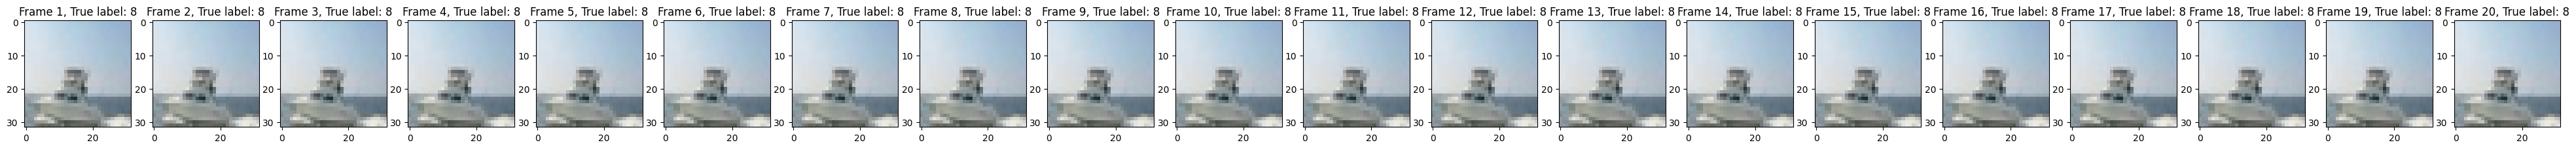

In [10]:

sample_index=100
# number of frames for each movie
num_frames=20

fig, axs= plt.subplots(1,num_frames,figsize=(50,30),subplot_kw={'aspect':'equal'})

# loop through the frames 
for i in range(num_frames):
  frame_label=str(np.argmax(y_train[sample_index]))
  axs[i].set_title(f"Frame {i+1}, True label: {frame_label}")
  axs[i].imshow(x_train_movie[sample_index,i,:,:,:])


plt.show()

# **Masks**



## **Binary Mask**

In [11]:
## Binary Mask 
def modify_brightness_mask7(img,min_spotlight_intensity,max_spotlight_intensity):
  
  # randomly generate a spotlight intensity within the given min and max range
  spotlight_intensity=np.random.uniform(min_spotlight_intensity,max_spotlight_intensity)

  # width and height of the image 
  image_shape=img.shape[:2]

  # Create a binary mask with the same shape as CFAR10
  mask_2d=np.random.randint(0,5,size=image_shape)

  # Shuffle the indices in the 2D mask 
  shuffled_indices=np.random.permutation(np.arange(mask_2d.size))

  # Apply the shuffle indices to the 2D mask
  shuffled_mask= mask_2d.reshape(-1)[shuffled_indices]

  # reshape the shuffled mask to the original image shape
  shuffled_mask_2d=shuffled_mask.reshape(image_shape)
 
  # # Binary mask: if the pixel value> mean value of all pixels set to 1, otherwise set to 0 
  binary_mask = np.where(shuffled_mask_2d > np.mean(shuffled_mask_2d), 1, 0)
 

  
  # Replicate the binary mask across all three channels (RGB)
  mask_3d = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)

  # apply the light intensity
  img_mod=img.copy()
  img_mod=img_mod*((mask_3d*spotlight_intensity)+1)

 
  # # Clip the pixel values to the valid range
  # img_mod = np.clip(img_mod, 0, 1)

  return img_mod, spotlight_intensity

## **Circular Mask**

In [12]:
# Circular mask
def modify_brightness_mask6(img, min_spotlight_intensity, max_spotlight_intensity):
    # generate random choice
    cx = np.random.randint(4, 24)
    cy = np.random.randint(4, 24)
    r = np.random.randint(4, 12)

    # create a mask
    mask_circ = np.ones_like(img)
    y, x = np.ogrid[-cy:img.shape[0] - cy, -cx:img.shape[1] - cx]  # Swap the cx and cy positions here
    mask_condition = (x**2 + y**2) <= r**2

    # randomly generate a spotlight intensity within the given min and max range
    spotlight_intensity = np.random.uniform(min_spotlight_intensity, max_spotlight_intensity)


    for c in range(img.shape[-1]):
        mask_circ[..., c][mask_condition] = spotlight_intensity  

    # apply the mask to the image
    img_mod = img.copy()
    masked_img_circ = ((mask_circ) * img_mod)
    
    # Clip the pixel values to the valid range
    # masked_img_circ = np.clip(masked_img_circ, 0, 1)

    return masked_img_circ,spotlight_intensity

# **Create a movie with mask- Test Dataset**

In [13]:
# Create a movie with a mask being generated seperately for each of the consecutive frames 

def create_movie_with_mask(data, labels, repeat, mask_frames_list, spotlight_intensity_min, spotlight_intensity_max):
    n_samples, img_height, img_width, img_channel = data.shape
    movie_data = np.zeros((n_samples, repeat, img_height, img_width, img_channel), dtype=np.float32)
    movie_labels = np.zeros((n_samples, num_classes), dtype=int)
    category_labels = []
    intensity_values=[]

    for i in range(n_samples):
        # Choose a random number from mask_frames_list
        mask_frames = np.random.choice(mask_frames_list)

        # Choose a random starting frame for this sample
        mask_start = np.random.randint(0, repeat - mask_frames + 1)

        # Assign a category label for each start frame and number of masked frames
        category_labels.append((mask_start, mask_frames))

        # Create a mask for this sample
        mask = None
        for j in range(repeat):
            if j >= mask_start and j < mask_start + mask_frames:
                if mask is None:
                    mask, intensity = modify_brightness_mask6(data[i], spotlight_intensity_min, spotlight_intensity_max)
                movie_data[i, j, :, :, :] = mask
                intensity_values.append(intensity )
            else:
                movie_data[i, j, :, :, :] = data[i]

        movie_labels[i] = labels[i]

    return movie_data, movie_labels, category_labels,intensity_values
    

In [14]:
spotlight_intensity_min=0.005
spotlight_intensity_max=100
mask_frames_list=[2,6,12]
repeats=20
x_test_mask_movie, movie_labels_mask_test, category_labe_labels, intensity_values=create_movie_with_mask(x_test,y_test,repeats,mask_frames_list,spotlight_intensity_min,spotlight_intensity_max)

In [ ]:
# x_test_mask_movie[1000]

## **Visualize the test dataset**


Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268
Intensity: 59.86785512728268


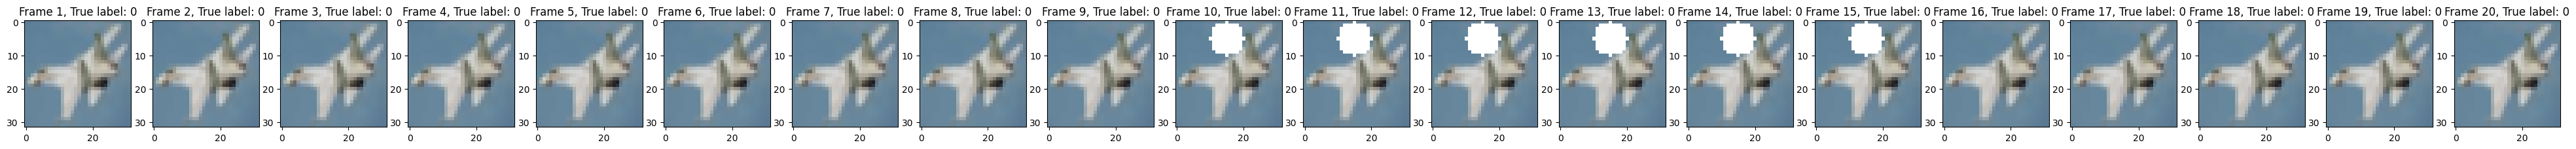

In [15]:

sample_index=10
# number of frames for each movie
num_frames=20

fig, axs= plt.subplots(1,num_frames,figsize=(50,30),subplot_kw={'aspect':'equal'})

# loop through the frames 
for i in range(num_frames):
  frame_label=str(np.argmax(y_test[sample_index]))
  intensity = intensity_values[sample_index]
  axs[i].set_title(f"Frame {i+1}, True label: {frame_label}")
  # img_for_display = ((x_test_mask_movie[sample_index,i,:,:,:]) * 255).astype('uint8')
  axs[i].imshow((x_test_mask_movie[sample_index,i,:,:,:]))
  # axs[i].imshow(img_for_display)
  print(f"Intensity: {intensity}")

plt.show()


# **Train dataset vs. test dataset**


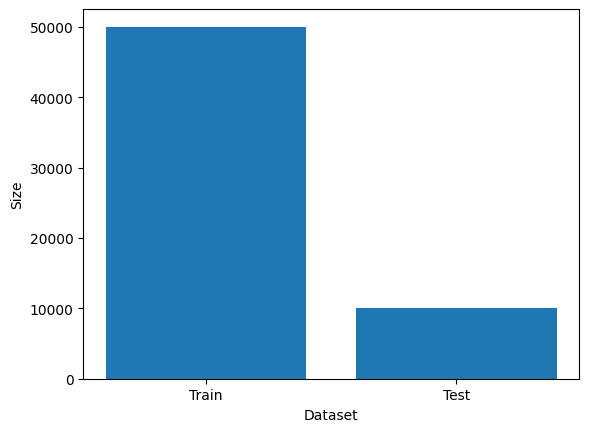

In [16]:
# # Plot a bar chart of the sizes

train_size=x_train_movie.shape[0]
test_size=x_test_mask_movie.shape[0]
# train_repeated_size=x_train_repeated.shape[0]
plt.bar(['Train', 'Test'], [train_size, test_size])
plt.xlabel('Dataset')
plt.ylabel('Size')
plt.show()

# **Models**

## **ResNet50 Model**

In [17]:
# ResNet50 Model 

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

frame_num = 20
input_shape = (32, 32, 3)
movie_input_shape = (frame_num, 32, 32, 3)
num_classes = 10



# ResNet50 base model
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# input layer ( movie)

input_layer = Input(shape=movie_input_shape)

# ResNet50 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet50_base)(input_layer)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

model1 = Model(inputs=input_layer, outputs=y2)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 32, 32, 3)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 20, 1, 1, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 2048)         0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 20, 2048)          0         
                                                                 
 dense (Dense)               (None, 20, 10)            20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-tra

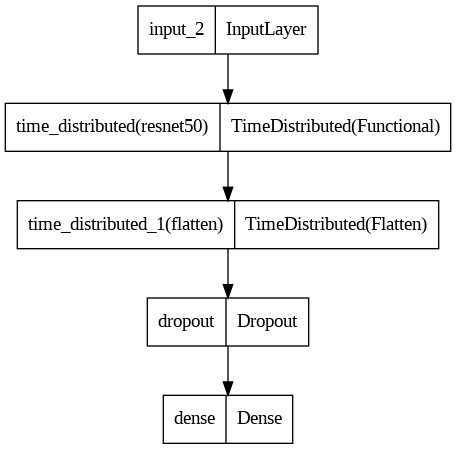

In [18]:
from keras.utils.vis_utils import plot_model
model=model1
plot_model(model1,to_file='Model1.png')

### **Data Generator**

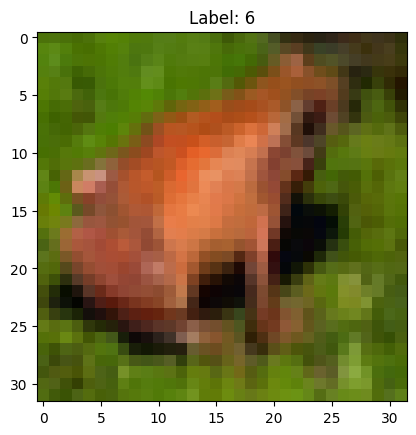

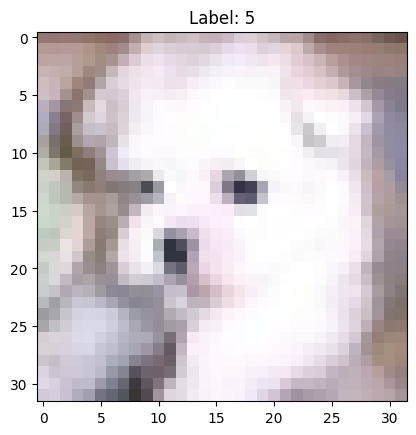

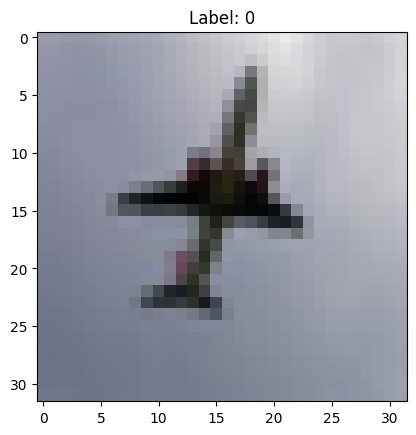

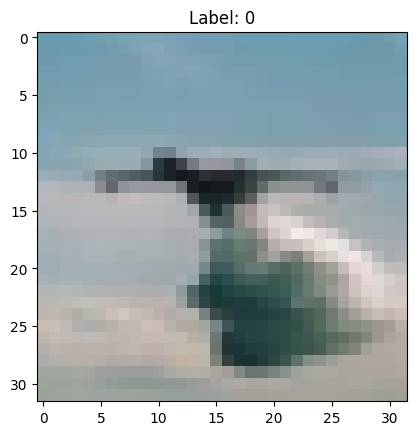

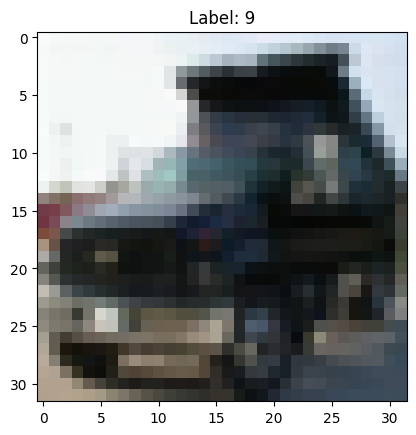

In [19]:
# 1. Verify data and labels alignment:

# Assuming x_data and y_labels are your loaded data and labels
num_samples = 5  # Number of random samples to visualize
frame_index=0

for _ in range(num_samples):
    idx = np.random.randint(0, len(x_train_movie))
    movie = x_train_movie[idx]
    frame=movie[frame_index]
    label = np.argmax(y_train[idx])

    # Visualize the sample and its label (assuming 28x28 images)
    plt.imshow(frame)
    plt.title(f"Label: {label}")
    plt.show()

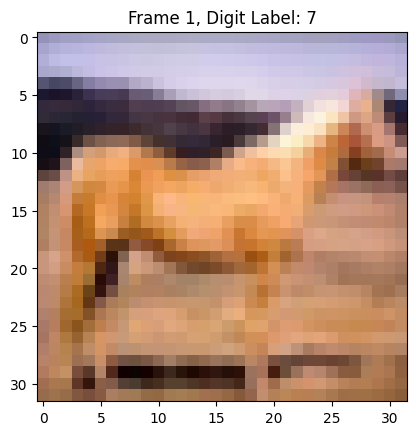

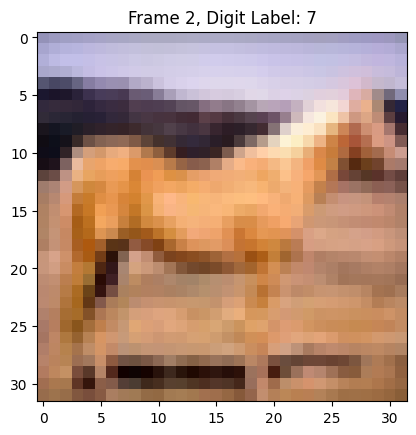

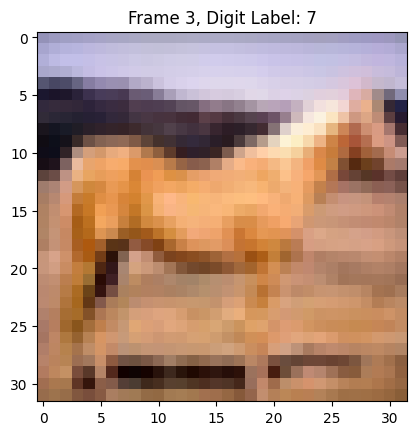

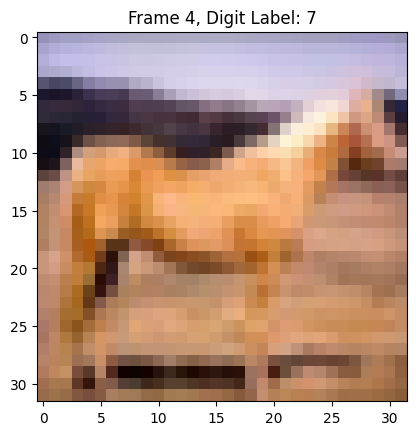

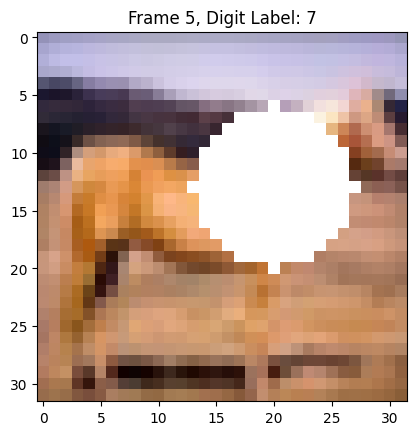

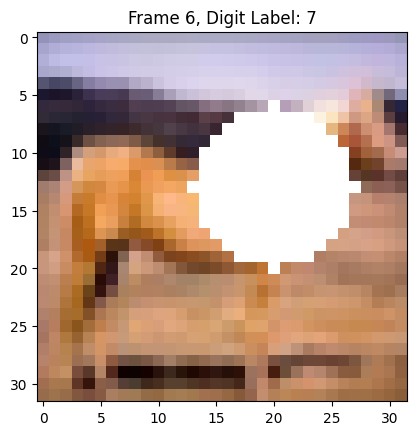

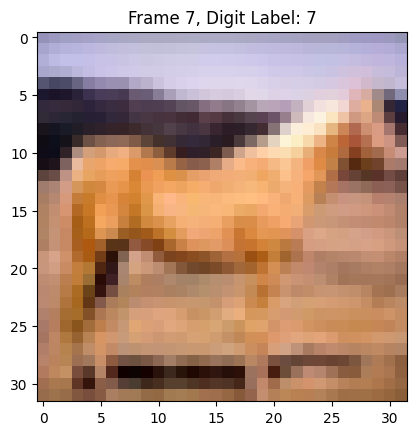

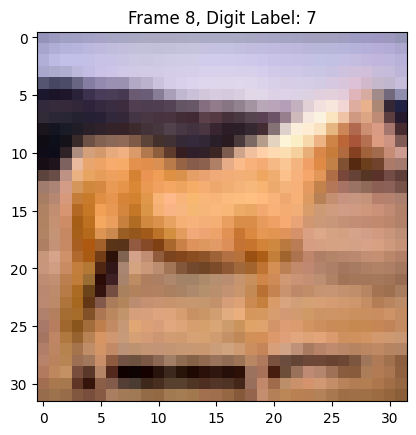

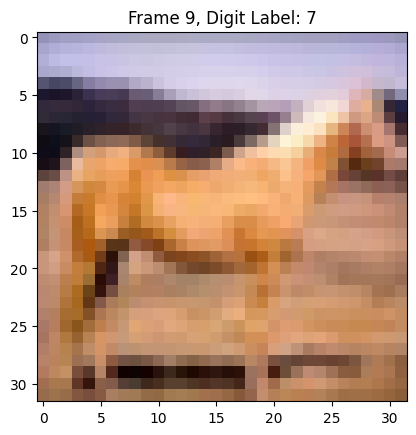

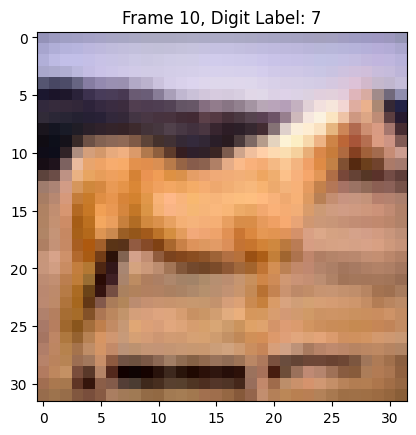

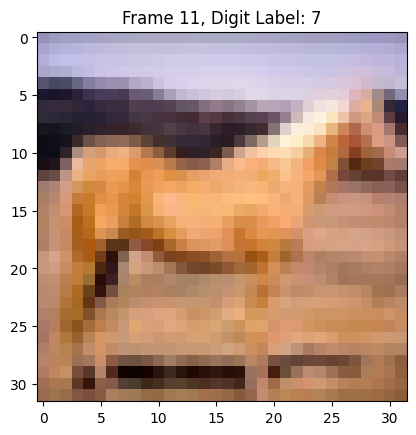

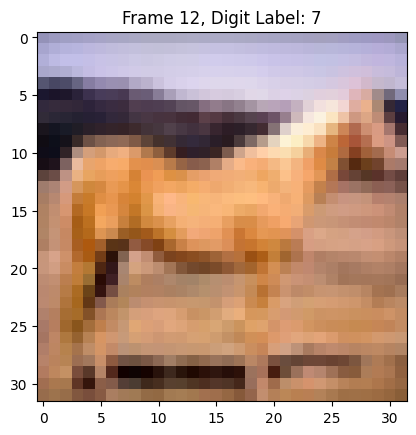

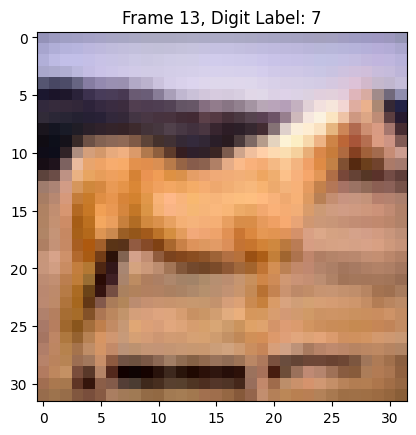

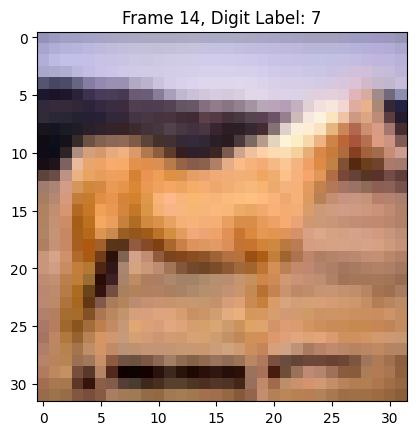

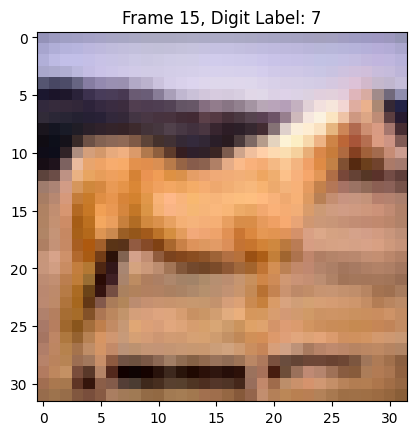

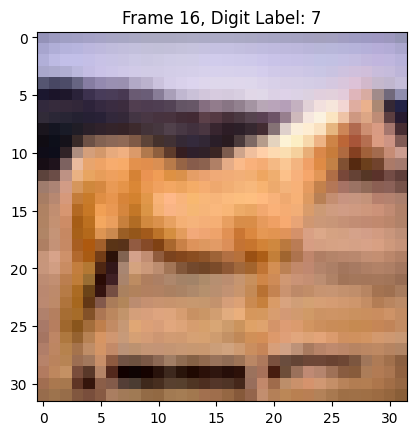

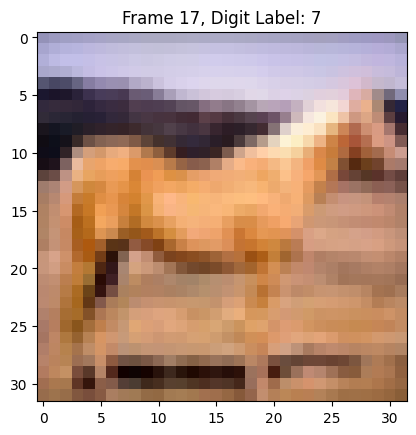

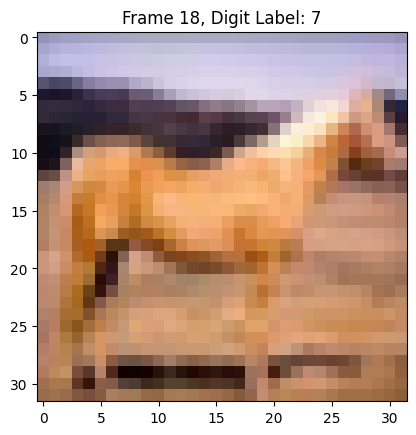

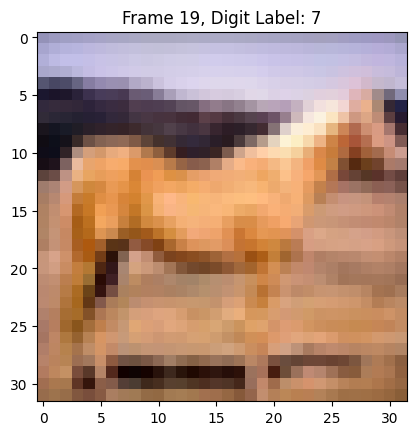

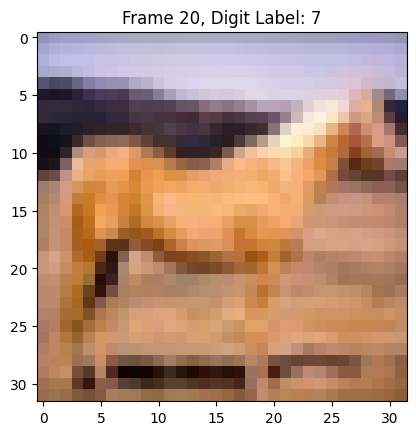

In [20]:
# 2. Visualize all the frames of a movie 
def visualize_movie_frames(x, y, movie_index):
    movie_data = x[movie_index]
    movie_labels = np.argmax(y[movie_index])

    frames = 20  # Change this to match the number of frames per movie

    # Get the digit label for the whole movie sequence
    digit_label = (movie_labels)

    # Iterate through the frames and visualize them with their corresponding label
    for i in range(frames):
        frame = movie_data[i]

        plt.imshow(frame)
        plt.title(f"Frame {i+1}, Digit Label: {digit_label}")
        plt.show()

# Call the function with the desired movie_index
movie_index = 700 # Change this to the index of the movie you want to visualize
visualize_movie_frames(x_test_mask_movie, y_test, movie_index)

In [21]:
# Movie level data generator 
def movie_level_data_generator(x, y, batch_size):
    n_samples = len(x)
    indices = np.arange(n_samples)
    frames = 20

    while True:
        np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]

            batch_x = np.array([x[i] for i in batch_idx])
            batch_y = y[batch_idx]

            # Repeat the labels for each frame in the movie
            batch_y = np.repeat(batch_y, frames, axis=0)
            
            # Reshape the labels to match the model's output shape
            batch_y = batch_y.reshape(-1, frames, 10)

            # Print the frame and its corresponding label for each movie in the batch
            for movie_idx, movie_data in enumerate(batch_x):
                for i in range(frames):
                    frame = movie_data[i, :, :]
                    label = batch_y[movie_idx, i, :]

                    digit = frame
                    digit_label = np.argmax(label)

                    
                    digit = digit.reshape(32, 32,3)

                    # plt.imshow(digit)
                    # plt.title(f"Movie {movie_idx+1}, Frame {i+1}, Digit Label: {digit_label}")
                    # plt.show()

            yield batch_x, batch_y

In [22]:
# Train dataset 
train_generator = movie_level_data_generator(x_train_movie, y_train, batch_size=16)
# Iterate over the generator 
x, y = next(train_generator)
# Test dataset
validation_generator = movie_level_data_generator(x_test_mask_movie, y_test, batch_size=16)
# Iterate over the generator 
x, y = next(validation_generator)
batch_size = 16
steps_per_epoch = len(x_train_movie) // batch_size
validation_steps = len(x_test_mask_movie) // batch_size

### **Compiling and Training the model**

In [ ]:
# one label per frame
# model 1: 100 epochs
from keras.callbacks import ModelCheckpoint
n = 300
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model1:ResNet50/model1.h5"

# create a callback that will save the model while training
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                            save_weights_only=False, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            save_best_only=True)
history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, 
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=[model_checkpoint_callback],
                      verbose=1)


Epoch 1/300
3125/3125 [==============================] - 209s 51ms/step - loss: 1.4622 - accuracy: 0.5335 - val_loss: 43.2759 - val_accuracy: 0.5030
Epoch 2/300
3125/3125 [==============================] - 158s 51ms/step - loss: 0.9371 - accuracy: 0.6861 - val_loss: 34.0308 - val_accuracy: 0.5184
Epoch 3/300
3125/3125 [==============================] - 160s 51ms/step - loss: 0.7557 - accuracy: 0.7487 - val_loss: 31.9962 - val_accuracy: 0.5683
Epoch 4/300
3125/3125 [==============================] - 160s 51ms/step - loss: 0.5986 - accuracy: 0.8010 - val_loss: 41.6473 - val_accuracy: 0.5760
Epoch 5/300
3125/3125 [==============================] - 156s 50ms/step - loss: 0.4856 - accuracy: 0.8386 - val_loss: 34.6652 - val_accuracy: 0.5740
Epoch 6/300
3125/3125 [==============================] - 160s 51ms/step - loss: 0.3950 - accuracy: 0.8701 - val_loss: 23.5482 - val_accuracy: 0.5806
Epoch 7/300
3125/3125 [==============================] - 161s 51ms/step - loss: 0.3084 - accuracy: 0.8978 

### **Load the model**


In [23]:
from keras.models import load_model

# specify the path to your model
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model1:ResNet50/model1.h5"

# load the model from the checkpoint
model1 = load_model(checkpoint_path)



### **Accuracy plot**


In [25]:

# convert to one-hot encoded 
y_test=np.argmax(y_test,axis=1)



# import matplotlib.pyplot as plt
frame_num=20
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
    # labels 
    movie_labels = (y_test[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor 
    movie_labels = movie_labels.reshape(frame_num, -1)
    
    # Predict the labels for each frame in the movieslack
    predicted_labels = model1.predict(movie_data.reshape(1, 20, 32, 32,3))
    
    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)
        

        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    
# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)



Streaming output truncated to the last 5000 lines.
Movie 9762, Frame 20 Accuracy: [ True],predicted_label:5, actual label:[5]
1/1 [==============================] - 0s 29ms/step
Movie 9763, Frame 1 Accuracy: [False],predicted_label:1, actual label:[6]
Movie 9763, Frame 2 Accuracy: [False],predicted_label:1, actual label:[6]
Movie 9763, Frame 3 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 4 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 5 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 6 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 7 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 8 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 9 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 10 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 11 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 

## **VGG 16 Model**


In [ ]:

# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

# frame_num = 20
# input_shape = (32, 32, 3)
# movie_input_shape = (frame_num, 32, 32, 3)
# num_classes = 10



# # Load the VGG16 base model
# vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# # input layer ( movie)
# input_layer = Input(shape=movie_input_shape)

# # ResNet50 base model with TimeDistributed layer
# resnet_td = TimeDistributed(vgg16_base)(input_layer)
# y2 = TimeDistributed(Flatten())(resnet_td)
# y2 = keras.layers.Dropout(0.5)(y2)
# y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# model2 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# from keras.utils.vis_utils import plot_model
# model=vgg16_base
# plot_model(vgg16_base,to_file='Model1.png')

### **Compiling and Training the model**


In [ ]:
# one label per frame
# n = 5
# model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, 
#                       validation_data=validation_generator, validation_steps=validation_steps,
#                       verbose=1)

### **Accuracy Plot**

In [ ]:
# # convert to one-hot encoded 
# # y_test=np.argmax(y_test,axis=1)



# # import matplotlib.pyplot as plt
# frame_num=20
# num_movies_all_correct=np.zeros(20)
# frame_accs=np.zeros(20)
# mismatched_movies=[]

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
#     # labels 
#     movie_labels = (y_test[movie_idx])
#     movie_labels = np.repeat(movie_labels, frame_num, axis=0)
#     # label tensor and frames tensor 
#     movie_labels = movie_labels.reshape(frame_num, -1)
    
#     # Predict the labels for each frame in the movieslack
#     predicted_labels = model2.predict(movie_data.reshape(1, 20, 32, 32, 3))
    
#     # Calculate the accuracy for each frame in the movie
#     mismatch_found = False
#     for frame_idx in range(20):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx] += (frame_acc)
        

#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]

#         print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    
# # Divide by the number of movies to get the mean accuracy for each frame
# frame_accs /= len(x_test_mask_movie)

## **EfficientNet**

In [ ]:
# import tensorflow.keras.applications as ap
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

# frame_num = 20
# input_shape = (32, 32, 3)
# movie_input_shape = (frame_num, 32, 32, 3)
# num_classes = 10



# # Load the VGG16 base model
# EfficientNet_base = ap.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)

# # input layer ( movie)
# input_layer = Input(shape=movie_input_shape)

# # ResNet50 base model with TimeDistributed layer
# resnet_td = TimeDistributed(EfficientNet_base)(input_layer)
# y2 = TimeDistributed(Flatten())(resnet_td)
# y2 = keras.layers.Dropout(0.5)(y2)
# y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# model3 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# from keras.utils.vis_utils import plot_model
# model=EfficientNet_base
# plot_model(EfficientNet_base,to_file='Model3.png')

In [ ]:
# # Choose a movie index to plot its frames
# movie_idx =3000

# # Get the data and labels for the chosen movie
# movie_data = x_test_mask_movie[movie_idx]
# movie_labels = y_test[movie_idx]

# # Repeat the labels for each frame in the movie ( the first frame is eliminated )
# frame_num = 20
# movie_labels = np.repeat(movie_labels, frame_num, axis=0)
# movie_labels = movie_labels.reshape(frame_num, -1)

# # Predict the labels for each frame in the movieslack
# predicted_labels = model1.predict(movie_data.reshape(1, 20, 32, 32,3))




# fig, axs = plt.subplots(1, num_frames, figsize=(100, 30), subplot_kw={'aspect': 'equal'})
# # loop through the frames and display each one separately
# for i in range(num_frames):
#     digit = movie_data[i, :, :]
#     digit_label = np.argmax(predicted_labels[0][i])
#     axs[i].imshow(digit)
#     axs[i].set_title(f"Movie {movie_idx+1}, Frame {i+1}, Digit Label: {digit_label}")
#     axs[i].axis('off')
   


# plt.show()

In [ ]:
# ### Input 
# # the index of the sample you want to display
# sample_index = 9991
# # the number of frames in each image
# num_frames = 20

# fig, axs = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

# # loop through the frames and display each one separately
# for i in range(num_frames):
#     axs[i].imshow(x_test_mask_movie[sample_index, i, :, :])
#     axs[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs[i].axis('off')

# plt.show()

## **PR+ResNet Model**

### **PR+ResNet Model(R+G+B)**

In [28]:
#CNN + PR Model (Time Distributed)- MNIST


from tensorflow.keras.regularizers import l1_l2

## ResNet Model 
frame_num = 20
num_classes = 10
chan1_n=20
chanl_col=3


output=[]
submodels_PR2=[]

# input_movie has three colors 
input_layer = Input(shape=(frame_num, 32, 32, 3))
input_shape = (20, 32, 32)
inputs = Input(shape=input_shape)

# Run the model for each color 

for i in range(chanl_col):

   
    # Split the channels
    channel_input = Lambda(lambda x: x[..., i:i+1])(input_layer)
    # squeezed_inputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(channel_input)


    # PR Architecture 
    y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]))(channel_input)
    y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
    y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-1],chan1_n))(y1)
    y1 = y1[:,:,:,:,:]


    output.append(y1)



concatenated_output=tf.keras.layers.Concatenate()(output)
y1_reduced = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1))(concatenated_output)



# # ResNet50 base model (pre-trained model)
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,chanl_col))


y2= TimeDistributed(ResNet50_base)(y1_reduced)
y2 = TimeDistributed(Flatten())(y2)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)


model3 = Model(inputs=input_layer, outputs=y2)
submodels_PR3=(Model(inputs=input_layer, outputs=y1))



In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 32, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 20, 32, 32,   0           ['input_3[0][0]']                
                                1)                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 20, 32, 32,   0           ['input_3[0][0]']                
                                1)                                                          

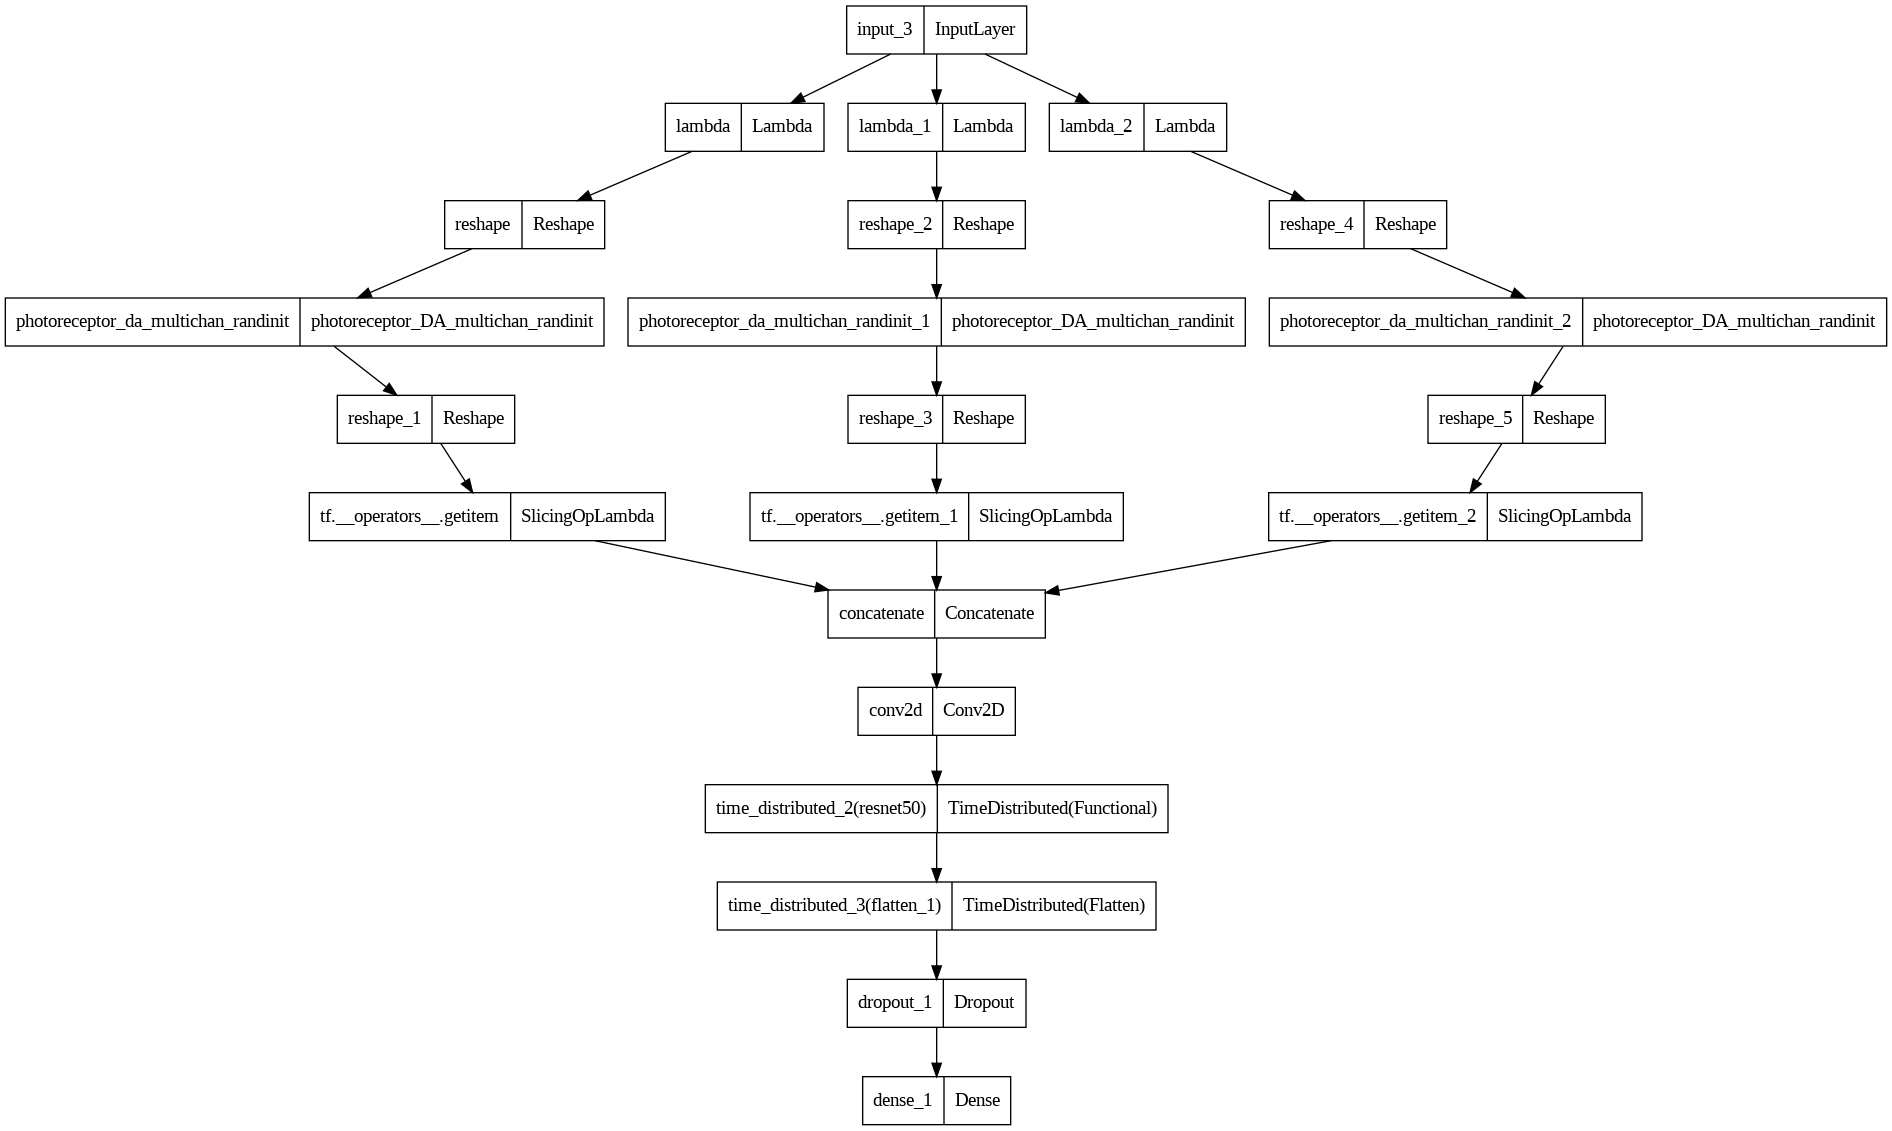

In [ ]:
from keras.utils.vis_utils import plot_model
model=model3
plot_model(model3,to_file='Model3.png')

#### **Compiling and Training**


In [26]:
# Load the model 
# from keras.models import load_model

# # specify the path to your model
# checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model3:ResNet50/model3.h5"
# custom_objects = {'photoreceptor_DA_multichan_randinit': photoreceptor_DA_multichan_randinit}
# # load the model from the checkpoint
# model3 = load_model(checkpoint_path,custom_objects=custom_objects)

In [ ]:
# # one label per frame
n = 300
n_initial=238
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model3:ResNet50/model3.h5"
model3.load_weights(checkpoint_path)


# create a callback that will save the model while training
# create a callback that will save the model while training
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                            save_weights_only=False, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            save_best_only=False)
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n,initial_epoch=n_initial, 
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=[model_checkpoint_callback],
                      verbose=1)


Epoch 239/300
3125/3125 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9585

In [ ]:
from keras.models import load_model

# specify the path to your model
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model3:ResNet50/model3.h5"

# load the model from the checkpoint
model3 = load_model(checkpoint_path)

In [ ]:

# # convert to one-hot encoded 
# y_test=np.argmax(y_test,axis=1)



# # import matplotlib.pyplot as plt
# frame_num=20
# num_movies_all_correct=np.zeros(20)
# frame_accs=np.zeros(20)
# mismatched_movies=[]

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
#     # labels 
#     movie_labels = (y_test[movie_idx])
#     movie_labels = np.repeat(movie_labels, frame_num, axis=0)
#     # label tensor and frames tensor 
#     movie_labels = movie_labels.reshape(frame_num, -1)
    
#     # Predict the labels for each frame in the movieslack
#     predicted_labels = model3.predict(movie_data.reshape(1, 20, 32, 32,3))
    
#     # Calculate the accuracy for each frame in the movie
#     mismatch_found = False
#     for frame_idx in range(20):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx] += (frame_acc)
        

#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]

#         print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    
# # Divide by the number of movies to get the mean accuracy for each frame
# frame_accs /= len(x_test_mask_movie)


### **Output channels vVisualization**

In [ ]:
# test_video = np.expand_dims(x_test_mask_movie[5609], axis=0)
# output = submodels_PR2.predict(test_video)

# num_frames = output.shape[1]
# num_chan = output.shape[-1]

# for j in range(num_chan):
#     frames_channel_j = []  # List to store frames of channel j

#     for i in range(num_frames):
#         frame_i_channel_j = output[0, i, :, :, j]
#         frames_channel_j.append(frame_i_channel_j)

#     # Combine frames of channel j into a single line
#     combined_frames = np.concatenate(frames_channel_j, axis=1)

#     # Display the combined frames
#     plt.figure(figsize=(10, 10))
#     plt.imshow(combined_frames)
#     plt.title(f'Channel {j+1}')  # Set the title of the plot
#     plt.show()

#### **Accuracy Plot**

In [ ]:
# ## Compare the accuracy of the CNN+PR model 

# import matplotlib.pyplot as plt
# import numpy as np


# frames_to_exclude = 2
# frame_num = 20 - frames_to_exclude
# frame_accs = np.zeros(frame_num)
# num_movies_all_correct = np.zeros(frame_num)

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
#     movie_labels = y_test[movie_idx]
#     movie_labels = np.repeat(movie_labels, frame_num+frames_to_exclude, axis=0)
#     movie_labels = movie_labels.reshape(frame_num+frames_to_exclude, -1)
    
#     # Predict the labels for each frame in the movie
#     predicted_labels = model3.predict(movie_data.reshape(1, 20, 32, 32,3))
    
#     # Calculate the accuracy for each frame in the movie, starting from the frame after those to exclude
#     for frame_idx in range(frames_to_exclude, frame_num+frames_to_exclude):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx - frames_to_exclude] += int(frame_acc)
        
#         # Display the digit image and its predicted label

#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]
#         # Print the accuracy for this frame
#         print(f"Movie {movie_idx+1}, Frame {frame_idx} Accuracy: {frame_acc}, predicted_label: {np.argmax(predicted_labels[0][frame_idx])}, actual label: {(movie_labels[frame_idx])}")


#                     # Check if all frames match the labels
#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(frames_to_exclude, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    


### **PR+ResNet50(RGB)**

In [ ]:
## PR+ CNN Model- CFAR10
from tensorflow.keras.layers import MaxPooling3D
## PR+ CNN Model- CFAR10

## ResNet Model 
frame_num = 20
num_classes = 10
chan1_n=20
chanl_col=3

# there are 3 channels (RBG) and 20 frames 
input_shape = (frame_num, 32, 32,chanl_col)

# define inputs tensor
inputs = Input(shape=input_shape)


# PR Architecture 

# reshape the input to PR (frame_num=20, width*height*colour=3072)
y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]*inputs.shape [-3]))(inputs)
y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
# reshape the output of PR (frame_num=20, width=32, height=32, channel_num*colour=60)
y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-3],chan1_n*inputs.shape [-1]))(y1)
# # leave the first 5 frames 
y1 = y1[:,:,:,:,:]

# ResNet is designed for colour images, add a maxpooling layer 

y1_reduced = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1))(y1)


# # ResNet50 base model (pre-trained model)
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,chanl_col))

y2= TimeDistributed(ResNet50_base)(y1_reduced)
y2 = TimeDistributed(Flatten())(y2)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

model5 = Model(inputs=inputs, outputs=y2)
submodels_PR2=(Model(inputs=inputs, outputs=y1))


In [ ]:
model5.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
model=model5
plot_model(model5,to_file='Model5.png')

#### **Compiling and Training**

In [ ]:
# # one label per frame
n = 300
model5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# specify the path to save the model
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model5:ResNet50/model5.h5"

# create a callback that will save the model while training
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                            save_weights_only=False, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            save_best_only=True)
history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, 
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=[model_checkpoint_callback],
                      verbose=1)

In [ ]:
from keras.models import load_model

# specify the path to your model
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model5:ResNet50/model5.h5"

# load the model from the checkpoint
model5 = load_model(checkpoint_path)

#### **Accuracy Plot**


In [ ]:
# # convert to one-hot encoded 
# y_test=np.argmax(y_test,axis=1)



# # import matplotlib.pyplot as plt
# frame_num=20
# num_movies_all_correct=np.zeros(20)
# frame_accs=np.zeros(20)
# mismatched_movies=[]

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
#     # labels 
#     movie_labels = (y_test[movie_idx])
#     movie_labels = np.repeat(movie_labels, frame_num, axis=0)
#     # label tensor and frames tensor 
#     movie_labels = movie_labels.reshape(frame_num, -1)
    
#     # Predict the labels for each frame in the movieslack
#     predicted_labels = model5.predict(movie_data.reshape(1, 20, 32, 32, 3))
    
#     # Calculate the accuracy for each frame in the movie
#     mismatch_found = False
#     for frame_idx in range(20):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx] += (frame_acc)
        

#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]

#         print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    
# # Divide by the number of movies to get the mean accuracy for each frame
# frame_accs /= len(x_test_mask_movie)

## **Untrained ResNet20**

In [ ]:
# from __future__ import print_function
# import keras
# import tensorflow as tf
# from keras.layers import Dense, Conv2D, BatchNormalization, Activation
# from keras.layers import AveragePooling2D, Input, Flatten
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras.callbacks import ReduceLROnPlateau
# from keras.preprocessing.image import ImageDataGenerator
# from keras.regularizers import l2
# from keras import backend as K
# from keras.models import Model
# from keras.datasets import cifar100,cifar10
# import numpy as np
# import os

# # Training parameters
# batch_size = 128  # orig paper trained all networks with batch_size=128
# epochs = 2000 #200
# data_augmentation = True
# # cifar100
# # num_classes = 100
# # cifar10
# num_classes = 10

# # Subtracting pixel mean improves accuracy
# subtract_pixel_mean = True

# # Model parameter
# # ----------------------------------------------------------------------------
# #           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# # Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
# #           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# # ----------------------------------------------------------------------------
# # ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# # ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# # ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# # ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# # ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# # ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# # ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# # ---------------------------------------------------------------------------
# n = 3

# # Model version
# # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
# version = 2

# # Computed depth from supplied model parameter n
# if version == 1:
#     depth = n * 6 + 2
# elif version == 2:
#     depth = n * 9 + 2

# # Model name, depth and version
# model_type = 'ResNet%dv%d' % (depth, version)

# ### DO NOT USE THIS  Load the CIFAR10 data.
# # (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # # Input image dimensions.
# # input_shape = x_train.shape[1:]

# # # Normalize data.
# # x_train = x_train.astype('float32') / 255
# # x_test = x_test.astype('float32') / 255

# ### If subtract pixel mean is enabled
# # if subtract_pixel_mean:
# #     x_train_mean = np.mean(x_train, axis=0)
# #     x_train -= x_train_mean
# #     x_test -= x_train_mean

# # print('x_train shape:', x_train.shape)
# # print(x_train.shape[0], 'train samples')
# # print(x_test.shape[0], 'test samples')
# # print('y_train shape:', y_train.shape)

# # Convert class vectors to binary class matrices.
# #y_train = keras.utils.to_categorical(y_train, num_classes)
# #y_test = keras.utils.to_categorical(y_test, num_classes)


# def lr_schedule(epoch):
#     """Learning Rate Schedule

#     Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
#     Called automatically every epoch as part of callbacks during training.

#     # Arguments
#         epoch (int): The number of epochs

#     # Returns
#         lr (float32): learning rate
#     """
#     lr = 1e-3
#     if epoch > 180:
#         lr *= 0.5e-3
#     elif epoch > 160:
#         lr *= 1e-3
#     elif epoch > 120:
#         lr *= 1e-2
#     elif epoch > 80:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr


# def resnet_layer(inputs,
#                  num_filters=16, #16
#                  kernel_size=3,
#                  strides=1,
#                  activation='relu',
#                  batch_normalization=True,
#                  conv_first=True):
#     """2D Convolution-Batch Normalization-Activation stack builder

#     # Arguments
#         inputs (tensor): input tensor from input image or previous layer
#         num_filters (int): Conv2D number of filters
#         kernel_size (int): Conv2D square kernel dimensions
#         strides (int): Conv2D square stride dimensions
#         activation (string): activation name
#         batch_normalization (bool): whether to include batch normalization
#         conv_first (bool): conv-bn-activation (True) or
#             bn-activation-conv (False)

#     # Returns
#         x (tensor): tensor as input to the next layer
#     """
#     conv = Conv2D(num_filters,
#                   kernel_size=kernel_size,
#                   strides=strides,
#                   padding='same',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=l2(1e-4))

#     x = inputs
#     if conv_first:
#         x = conv(x)
#         if batch_normalization:
#             x = BatchNormalization()(x)
#         if activation is not None:
#             x = Activation(activation)(x)
#     else:
#         if batch_normalization:
#             x = BatchNormalization()(x)
#         if activation is not None:
#             x = Activation(activation)(x)
#         x = conv(x)
#     return x


# def resnet_v1(input_shape, depth, num_classes=10):
#     """ResNet Version 1 Model builder [a]

#     Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
#     Last ReLU is after the shortcut connection.
#     At the beginning of each stage, the feature map size is halved (downsampled)
#     by a convolutional layer with strides=2, while the number of filters is
#     doubled. Within each stage, the layers have the same number filters and the
#     same number of filters.
#     Features maps sizes:
#     stage 0: 32x32, 16
#     stage 1: 16x16, 32
#     stage 2:  8x8,  64
#     The Number of parameters is approx the same as Table 6 of [a]:
#     ResNet20 0.27M
#     ResNet32 0.46M
#     ResNet44 0.66M
#     ResNet56 0.85M
#     ResNet110 1.7M

#     # Arguments
#         input_shape (tensor): shape of input image tensor
#         depth (int): number of core convolutional layers
#         num_classes (int): number of classes (CIFAR10 has 10)

#     # Returns
#         model (Model): Keras model instance
#     """
#     if (depth - 2) % 6 != 0:
#         raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
#     # Start model definition.
#     num_filters = 16
#     num_res_blocks = int((depth - 2) / 6)

#     inputs = Input(shape=input_shape)
#     x = resnet_layer(inputs=inputs)
#     # Instantiate the stack of residual units
#     for stack in range(3):
#         for res_block in range(num_res_blocks):
#             strides = 1
#             if stack > 0 and res_block == 0:  # first layer but not first stack
#                 strides = 2  # downsample
#             y = resnet_layer(inputs=x,
#                              num_filters=num_filters,
#                              strides=strides)
#             y = resnet_layer(inputs=y,
#                              num_filters=num_filters,
#                              activation=None)
#             if stack > 0 and res_block == 0:  # first layer but not first stack
#                 # linear projection residual shortcut connection to match
#                 # changed dims
#                 x = resnet_layer(inputs=x,
#                                  num_filters=num_filters,
#                                  kernel_size=1,
#                                  strides=strides,
#                                  activation=None,
#                                  batch_normalization=False)
#             x = keras.layers.add([x, y])
#             x = Activation('relu')(x)
#         num_filters *= 2

#     # Add classifier on top.
#     # v1 does not use BN after last shortcut connection-ReLU
#     x = AveragePooling2D(pool_size=8)(x)
#     y = Flatten()(x)
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)

#     # Instantiate model.
#     model = Model(inputs=inputs, outputs=outputs)
#     return model


# def resnet_v2(input_shape, depth, num_classes=100):
#     """ResNet Version 2 Model builder [b]

#     Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
#     bottleneck layer
#     First shortcut connection per layer is 1 x 1 Conv2D.
#     Second and onwards shortcut connection is identity.
#     At the beginning of each stage, the feature map size is halved (downsampled)
#     by a convolutional layer with strides=2, while the number of filter maps is
#     doubled. Within each stage, the layers have the same number filters and the
#     same filter map sizes.
#     Features maps sizes:
#     conv1  : 32x32,  16
#     stage 0: 32x32,  64
#     stage 1: 16x16, 128
#     stage 2:  8x8,  256

#     # Arguments
#         input_shape (tensor): shape of input image tensor
#         depth (int): number of core convolutional layers
#         num_classes (int): number of classes (CIFAR10 has 10)

#     # Returns
#         model (Model): Keras model instance
#     """
#     if (depth - 2) % 9 != 0:
#         raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
#     # Start model definition.
#     num_filters_in = 16
#     num_res_blocks = int((depth - 2) / 9)

#     inputs = Input(shape=input_shape)
#     # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
#     x = resnet_layer(inputs=inputs,
#                      num_filters=num_filters_in,
#                      conv_first=True)

#     # Instantiate the stack of residual units
#     for stage in range(3):
#         for res_block in range(num_res_blocks):
#             activation = 'relu'
#             batch_normalization = True
#             strides = 1
#             if stage == 0:
#                 num_filters_out = num_filters_in * 4
#                 if res_block == 0:  # first layer and first stage
#                     activation = None
#                     batch_normalization = False
#             else:
#                 num_filters_out = num_filters_in * 2
#                 if res_block == 0:  # first layer but not first stage
#                     strides = 2    # downsample

#             # bottleneck residual unit
#             y = resnet_layer(inputs=x,
#                              num_filters=num_filters_in,
#                              kernel_size=1,
#                              strides=strides,
#                              activation=activation,
#                              batch_normalization=batch_normalization,
#                              conv_first=False)
#             y = resnet_layer(inputs=y,
#                              num_filters=num_filters_in,
#                              conv_first=False)
#             y = resnet_layer(inputs=y,
#                              num_filters=num_filters_out,
#                              kernel_size=1,
#                              conv_first=False)
#             if res_block == 0:
#                 # linear projection residual shortcut connection to match
#                 # changed dims
#                 x = resnet_layer(inputs=x,
#                                  num_filters=num_filters_out,
#                                  kernel_size=1,
#                                  strides=strides,
#                                  activation=None,
#                                  batch_normalization=False)
#             x = keras.layers.add([x, y])

#         num_filters_in = num_filters_out

#     # Add classifier on top.
#     # v2 has BN-ReLU before Pooling
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = AveragePooling2D(pool_size=8)(x)
#     y = Flatten()(x)
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)

#     # Instantiate model.
#     model = Model(inputs=inputs, outputs=outputs)
#     return model


# if version == 2:
#     model = resnet_v2(input_shape=input_shape, depth=depth)
# else:
#     model = resnet_v1(input_shape=input_shape, depth=depth)

# #from keras.optimizers import Adam
# #sparse_categorical...

# model.compile(loss='SparseCategoricalCrossentropy',
#               optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
#               metrics=tf.keras.metrics.SparseCategoricalAccuracy())
# model.summary()
# print(model_type)

# # Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)

# # Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]

# # Run training, with or without data augmentation.
# if not data_augmentation:
#     print('Not using data augmentation.')
#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True,
#               callbacks=callbacks)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         # set input mean to 0 over the dataset
#         featurewise_center=False,
#         # set each sample mean to 0
#         samplewise_center=False,
#         # divide inputs by std of dataset
#         featurewise_std_normalization=False,
#         # divide each input by its std
#         samplewise_std_normalization=False,
#         # apply ZCA whitening
#         zca_whitening=False,
#         # epsilon for ZCA whitening
#         zca_epsilon=1e-06,
#         # randomly rotate images in the range (deg 0 to 180)
#         rotation_range=0,
#         # randomly shift images horizontally
#         width_shift_range=0.1,
#         # randomly shift images vertically
#         height_shift_range=0.1,
#         # set range for random shear
#         shear_range=0.,
#         # set range for random zoom
#         zoom_range=0.,
#         # set range for random channel shifts
#         channel_shift_range=0.,
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         # value used for fill_mode = "constant"
#         cval=0.,
#         # randomly flip images
#         horizontal_flip=True,
#         # randomly flip images
#         vertical_flip=False,
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for featurewise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                         validation_data=(x_test, y_test),
#                         epochs=epochs, verbose=1, workers=4,
#                         callbacks=callbacks)

# # Score trained model.
# scores = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100,cifar10
import numpy as np
import os


# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 2000 
# cifar10
num_classes = 10



# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3

    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16, #16
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=100):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    # outputs = Dense(num_classes,
    #                 activation='softmax',
    #                 kernel_initializer='he_normal')(y)
    outputs = y

    # Instantiate model.
    resnet_v2 = Model(inputs=inputs, outputs=outputs)
    return resnet_v2 

### **ReNet20+PR(RGB)**

In [ ]:
frame_num = 20
num_classes = 10
# input_shape = (32, 32, 3)
# movie_input_shape = (frame_num, 32, 32, 3)
depth=20
chan1_n=20
chanl_col=3
input_shape_res=(32, 32, 60)

# there are 3 channels (RBG) and 20 frames 
input_shape = (frame_num, 32, 32,chanl_col)

# define inputs tensor
inputs = Input(shape=input_shape)
# PR Architecture 

# reshape the input to PR (frame_num=20, width*height*colour=3072)
y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]*inputs.shape [-3]))(inputs )
y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
# reshape the output of PR (frame_num=20, width=32, height=32, channel_num*colour=60)
y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-3],chan1_n*inputs.shape [-1]))(y1)
# # leave the first 5 frames 
y1 = y1[:,:,:,:,:]

# ResNet20 base model
ResNet20_image = resnet_v2(input_shape_res, depth, num_classes)

# # input layer ( movie)

# input_layer = Input(shape=movie_input_shape)

# ResNet20 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet20_image)(y1)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

model2 = Model(inputs=inputs, outputs=y2)

In [ ]:
ResNet20_image.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
model=model2
plot_model(model2,to_file='model2.png')

In [ ]:
# Compile the model 

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])


# Prepare model model saving directory.
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model2:ResNet20'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                      validation_data=validation_generator, validation_steps=validation_steps,
                      verbose=1, workers=1,
                        callbacks=callbacks)



In [ ]:
# # convert to one-hot encoded 
# y_test=np.argmax(y_test,axis=1)



# # import matplotlib.pyplot as plt
# frame_num=20
# num_movies_all_correct=np.zeros(20)
# frame_accs=np.zeros(20)
# mismatched_movies=[]

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):
    
#     # labels 
#     movie_labels = (y_test[movie_idx])
#     movie_labels = np.repeat(movie_labels, frame_num, axis=0)
#     # label tensor and frames tensor 
#     movie_labels = movie_labels.reshape(frame_num, -1)
    
#     # Predict the labels for each frame in the movieslack
#     predicted_labels = model2.predict(movie_data.reshape(1, 20, 32, 32, 3))
    
#     # Calculate the accuracy for each frame in the movie
#     mismatch_found = False
#     for frame_idx in range(20):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx] += (frame_acc)
        

#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]

#         print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")
    
# # Divide by the number of movies to get the mean accuracy for each frame
# frame_accs /= len(x_test_mask_movie)

### **PR+ResNet20(R+G+B)**

In [ ]:
## PR+ResNet20 

frame_num = 20
num_classes = 10
chan1_n=20
chanl_col=3

input_shape_res=(32, 32, 60)

input_shape = (20, 32, 32)
inputs = Input(shape=input_shape)

input_layer = Input(shape=(frame_num, 32, 32, 3))



output=[]
submodels_PR2=[]

for i in range(chanl_col):

   
    # Split the channels
    channel_input = Lambda(lambda x: x[..., i:i+1])(input_layer)
    squeezed_inputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(channel_input)


    # PR Architecture 
    y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]))(channel_input)
    y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
    y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-1],chan1_n))(y1)
    y1 = y1[:,:,:,:,:]


    output.append(y1)



concatenated_output=tf.keras.layers.Concatenate()(output)

# # ResNet20 base model
ResNet20_image = resnet_v2(input_shape_res, depth, num_classes)

# # input layer ( movie)

# input_layer = Input(shape=movie_input_shape)

# ResNet20 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet20_image)(concatenated_output)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

model4 = Model(inputs=input_layer , outputs=y2)

In [ ]:
from keras.utils.vis_utils import plot_model
model=model4
plot_model(model4,to_file='model4.png')

In [ ]:
# Compile the model 

model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])


# Prepare model model saving directory.
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model4:ResNet20'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                      validation_data=validation_generator, validation_steps=validation_steps,
                      verbose=1, workers=1,
                        callbacks=callbacks)
